# Implementación de una red AC-GAN con Keras<a id="top"></a>

<i><small>Autor: Algigantix<br>Última actualización: 2023-04-28</small></i></div>

## Introducción

Las redes generativas adversariales (GAN, de _Generative Adversarial Networks_) fueron presentadas por primera vez por Goodfellow et al. en el artículo [Generative Adversarial Networks](https://arxiv.org/abs/1406.2661) publicado en 2014. Este tipo de redes pueden ser utilizadas para la generación sintética de datos prácticamente idénticos a los originales.

Para la generación de estos datos se usan dos redes neuronales durante el entrenamiento: la **generadora**, que acepta un vector de entrada de ruido generado aleatoriamente y produce los datos de salida de aspecto similar a los datos auténticos, y la **discriminadora**, que intenta determinar si los datos que se le presentan son auténticos o generados.

Entrenando estas redes al mismo tiempo, una retroalimentando a la otra, dispondremos de un medio para generar datos prácticamente indistinguibles de los originales, o visto de otro modo, dispondremos de un medio para determinar si unos determinados datos son verdaderos o _fake_.

Una AC-GAN (_Auxiliary Classifier GAN_) es una variante en la que se incluye la clasificación por clases en la entrada de las dos redes, y la red discriminadora puede clasificar según probabilidad de que una imagen sea de una clase u  otra. Además emplean redes de convolución.

En nuestro caso, diseñaremos una red ACGAN que trate de falsificar algunos de los billetes de euro más comunes.

## Imports y configuración

Primero importamos las bibliotecas que necesitamos:
* enum: por definir las clases como una enumeración.
* tensorflow y keras: para lo relacionado con Redes de Neuronas (capas, optimizadores, algunos gráficos, modelos y guardar y cargar modelos).
* math: algunas funciones matemáticas.
* matplotlib.pyplot: elementos gráficos.
* numpy algunas operaciones sobre matrices, incluidas matrices aleatorias para el ruido.

Para facilitarnos la vida hemos decidido importar las capas directamente para no añadir un montón de texto.

In [3]:
#import collections # sería por el deque

import enum

import tensorflow as tf

from keras.initializers import RandomNormal

from keras.layers import Activation
from keras.layers import BatchNormalization
from keras.layers import Concatenate
from keras.layers import Conv2D
from keras.layers import Conv2DTranspose
from keras.layers import Dense
from keras.layers import Dropout
from keras.layers import Embedding
from keras.layers import Flatten
from keras.layers import Input
from keras.layers import LeakyReLU
from keras.layers import Reshape

from keras.models import Model
from keras.models import load_model

from keras.optimizers import Adam

from keras.utils.vis_utils import plot_model

from math import sqrt

import matplotlib.pyplot as plt

#import numpy as np
from numpy import asarray
from numpy import ones
from numpy import zeros
from numpy import expand_dims
from numpy.random import randn
from numpy.random import randint

También incluimos un pip por si faltan algunos paquetes en la instalación

In [12]:
!pip install pydot

Defaulting to user installation because normal site-packages is not writeable



[notice] A new release of pip is available: 23.0.1 -> 23.1.2
[notice] To update, run: python.exe -m pip install --upgrade pip


Asimismo algunas configuraciones gráficas.

In [4]:
%matplotlib notebook
plt.style.use('ggplot')
plt.rcParams.update({'figure.figsize': (15, 8),'figure.dpi': 64})

## El dataset que usaremos

Utilizaremos un dataset propio de billetes de 5€, 10€, 20€ y 50€, con una dimensión de imágenes predeterminada por nosotros y de 3 canales.

Como se dice en [este estudio](https://arxiv.org/pdf/1610.09585.pdf), una mayor resolución ayuda en la discriminación de billetes.

In [3]:
WIDTH, HEIGHT, CHANNELS = 640, 480, 3

In [5]:
# Cargar imágenes TO-DO clasificar chicos, id buscando como cargar imágenes
# TO-DO BUSCAD COMO CARGAR IMAGENES NUESTRAS

(x_train, _), (x_test, _) = tf.keras.datasets.mnist.load_data() #load_data()
dataset = np.concatenate((x_train, x_test))

print(f'Real images: {dataset.shape}')


# plot raw pixel data

# plot images from the training dataset
for i in range(100):
 # define subplot
 plt.subplot(10, 10, 1 + i)
 # turn off axis
 plt.axis('off')
 # plot raw pixel data
 plt.imshow(dataset[i])
plt.show()

Real images: (70000, 28, 28)


NameError: name 'load_data' is not defined

También definiremos las clases de billetes, pero indicando que solo usaremos 4

In [19]:
class Billetes(enum.Enum):
    """Cada una de los posibles billetes a falsificar."""
    los5euros = 0
    los10euros = 1
    los20euros = 2
    los50euros = 3
    los100euros = 4
    los200euros = 5
    los500euros = 6

In [18]:
num_billetes = 4

## Red generadora

La parte generadora de un modelo ACGAN se encarga de generar datos nuevos a partir de ruido aleatorio y una clase. Es de esperar que, a la larga, sea capaz de generar nuevos datos con una distribución similar a la de los elementos reales.

Y ya que hemos dicho _ruido aleatorio_, vamos con la definición de la longitud del vector de valores de entrada de ruido.

In [ ]:
# Esto es un test, TO-DO borrar
test = np.zeros(num_billetes)
print(test)
print(Billetes.los20euros.value)
test[Billetes.los20euros.value] = 1

print(test)

In [7]:
HIDDEN_FEATURES = 128

In [26]:
def create_generator(hidden_features, output_shape, clase):
    #TO-DO prueba primero billetes en blaco y negro y luego a color
    #in_label = tf.keras.layers.Input(shape=(1,))

    clasecilla =  np.zeros(num_billetes)
    clasecilla[clase.value] = 1
    
    # embedding for categorical input
    #li = tf.keras.layers.Embedding(num_billetes, 50)(in_label)
    # linear multiplication
    n_nodes = 7 * 7
    li = tf.keras.layers.Dense(n_nodes, input_shape=(1, num_billetes))(clasecilla)
    # reshape to additional channel
    li = tf.keras.layers.Reshape((7, 7, 3))(li)
    
    in_lat = tf.keras.layers.Input(shape=(hidden_features,))
    
    # foundation for 160x160 image
    # 640 x 480 --- m.c.m. 160
    n_nodes = 384 * 160 * 160
    gen = Dense(n_nodes, kernel_initializer=init)(in_lat)
    gen = Activation('relu')(gen)
    gen = Reshape((7, 7, 384))(gen)
    # merge image gen and label input
    merge = Concatenate()([gen, li])
    
    # upsample to 320x160
    gen = Conv2DTranspose(192, (5,5), strides=(2,1), padding='same', kernel_initializer=init)(merge)
    gen = BatchNormalization()(gen)
    gen = Activation('relu')(gen)
    # upsample to 640x160
    gen = Conv2DTranspose(192, (5,5), strides=(2,1), padding='same', kernel_initializer=init)(merge)
    gen = BatchNormalization()(gen)
    gen = Activation('relu')(gen)
    # upsample to 640x480
    gen = Conv2DTranspose(1, (5,5), strides=(1,3), padding='same', kernel_initializer=init)(gen)
    out_layer = Activation('tanh')(gen)
    # define model
    model = Model([in_lat, in_label], out_layer, name='Generator')
    
    return model
    
    #return tf.keras.models.Sequential([
    #    
    #    tf.keras.layers.Input(shape=(hidden_features,)),      
    #    tf.keras.layers.Dense(128, activation=tf.keras.layers.LeakyReLU(alpha=0.2)),
    #    tf.keras.layers.BatchNormalization(momentum=0.8),
    #    tf.keras.layers.Dense(128, activation=tf.keras.layers.LeakyReLU(alpha=0.2)),
    #    tf.keras.layers.BatchNormalization(momentum=0.8),
    #    tf.keras.layers.Dense(WIDTH*HEIGHT*CHANNELS, activation='sigmoid'),
    #    tf.keras.layers.Reshape(output_shape)
    #], name='Generator')

In [ ]:
 # weight initialization
 init = RandomNormal(stddev=0.02)
 # label input
 in_label = Input(shape=(1,))
 # embedding for categorical input
 li = tf.keras.layers.Embedding(n_classes, 50)(in_label)
 # linear multiplication
 n_nodes = 7 * 7
 li = tf.keras.layers.Dense(n_nodes, kernel_initializer=init)(li)
 # reshape to additional channel
 li = tf.keras.layers.Reshape((7, 7, 1))(li)
 # image generator input
 in_lat = Input(shape=(latent_dim,))
 # foundation for 7x7 image
 n_nodes = 384 * 7 * 7
 gen = Dense(n_nodes, kernel_initializer=init)(in_lat)
 gen = Activation('relu')(gen)
 gen = Reshape((7, 7, 384))(gen)
 # merge image gen and label input
 merge = Concatenate()([gen, li])
 # upsample to 14x14
 gen = Conv2DTranspose(192, (5,5), strides=(2,2), padding='same', kernel_initializer=init)(merge)
 gen = BatchNormalization()(gen)
 gen = Activation('relu')(gen)
 # upsample to 28x28
 gen = Conv2DTranspose(1, (5,5), strides=(2,2), padding='same', kernel_initializer=init)(gen)
 out_layer = Activation('tanh')(gen)
 # define model
 model = Model([in_lat, in_label], out_layer, name='Generator')
 return model

In [ ]:
generator = create_generator(HIDDEN_FEATURES, (WIDTH, HEIGHT, CHANNELS))
tf.keras.utils.plot_model(generator, show_shapes=True, show_layer_names=True)

## Red discriminadora

Ahora que tenemos el generador, procedemos a crear un discriminador, que en este caso nos dirá no solo si es auténtica o falsa, sino de cuál clase es.

La utilización de dropouts no es solo para reducir el sobreajuste, sino por cómo funciona una GAN, en la que para que se vaya aprendiendo la red competidora debe fallar un poco, porque si una red aprende demasiado rápido entonces la otra no aprende. Como en nuestro caso lo que nos interesa es falsificar billetes, nos interesa que el discriminador no aprenda demasiado rápido.

In [27]:
def create_discriminator(input_shape,):
    return tf.keras.models.Sequential([
        tf.keras.layers.Flatten(input_shape=input_shape),
        tf.keras.layers.Dense(32, activation=tf.keras.layers.LeakyReLU(alpha=0.2)),
        tf.keras.layers.Dropout(0.9),
        tf.keras.layers.Dense(1, activation='sigmoid'),
        tf.keras.layers.Dropout(0.5),
    ], name='Discriminator')

'''
 # weight initialization
 init = RandomNormal(stddev=0.02)
 # image input
 in_image = Input(shape=in_shape)
 # downsample to 14x14
 fe = Conv2D(32, (3,3), strides=(2,2), padding='same', kernel_initializer=init)(in_image)
 fe = LeakyReLU(alpha=0.2)(fe)
 fe = Dropout(0.5)(fe)
 # normal
 fe = Conv2D(64, (3,3), padding='same', kernel_initializer=init)(fe)
 fe = BatchNormalization()(fe)
 fe = LeakyReLU(alpha=0.2)(fe)
 fe = Dropout(0.5)(fe)
 # downsample to 7x7
 fe = Conv2D(128, (3,3), strides=(2,2), padding='same', kernel_initializer=init)(fe)
 fe = BatchNormalization()(fe)
 fe = LeakyReLU(alpha=0.2)(fe)
 fe = Dropout(0.5)(fe)
 # normal
 fe = Conv2D(256, (3,3), padding='same', kernel_initializer=init)(fe)
 fe = BatchNormalization()(fe)
 fe = LeakyReLU(alpha=0.2)(fe)
 fe = Dropout(0.5)(fe)
 # flatten feature maps
 fe = Flatten()(fe)
 # real/fake output
 out1 = Dense(1, activation='sigmoid')(fe)
 # class label output
 out2 = Dense(n_classes, activation='softmax')(fe)
 # define model
 model = Model(in_image, [out1, out2])
 # compile model
 opt = Adam(lr=0.0002, beta_1=0.5)
 model.compile(loss=['binary_crossentropy', 'sparse_categorical_crossentropy'], optimizer=opt)
 return model
'''

"\n # weight initialization\n init = RandomNormal(stddev=0.02)\n # image input\n in_image = Input(shape=in_shape)\n # downsample to 14x14\n fe = Conv2D(32, (3,3), strides=(2,2), padding='same', kernel_initializer=init)(in_image)\n fe = LeakyReLU(alpha=0.2)(fe)\n fe = Dropout(0.5)(fe)\n # normal\n fe = Conv2D(64, (3,3), padding='same', kernel_initializer=init)(fe)\n fe = BatchNormalization()(fe)\n fe = LeakyReLU(alpha=0.2)(fe)\n fe = Dropout(0.5)(fe)\n # downsample to 7x7\n fe = Conv2D(128, (3,3), strides=(2,2), padding='same', kernel_initializer=init)(fe)\n fe = BatchNormalization()(fe)\n fe = LeakyReLU(alpha=0.2)(fe)\n fe = Dropout(0.5)(fe)\n # normal\n fe = Conv2D(256, (3,3), padding='same', kernel_initializer=init)(fe)\n fe = BatchNormalization()(fe)\n fe = LeakyReLU(alpha=0.2)(fe)\n fe = Dropout(0.5)(fe)\n # flatten feature maps\n fe = Flatten()(fe)\n # real/fake output\n out1 = Dense(1, activation='sigmoid')(fe)\n # class label output\n out2 = Dense(n_classes, activation='softmax'

In [ ]:
discriminator = create_discriminator(input_shape=(WIDTH, HEIGHT, CHANNELS))
tf.keras.utils.plot_model(discriminator, show_shapes=True, show_layer_names=False)

In [29]:
#TO-DO PRUEBA EL EJEMPLO DE LAS ZAPATILLAS ENTERO ACÁ ABAJO Y LO AJUSTAS https://machinelearningmastery.com/how-to-develop-an-auxiliary-classifier-gan-ac-gan-from-scratch-with-keras/

In [1]:
# example of loading the fashion_mnist dataset
from keras.datasets.fashion_mnist import load_data
# load the images into memory
(trainX, trainy), (testX, testy) = load_data()
# summarize the shape of the dataset
print('Train', trainX.shape, trainy.shape)
print('Test', testX.shape, testy.shape)

4422102/4422102 [==============================] - 1s 0us/step
Train (60000, 28, 28) (60000,)
Test (10000, 28, 28) (10000,)


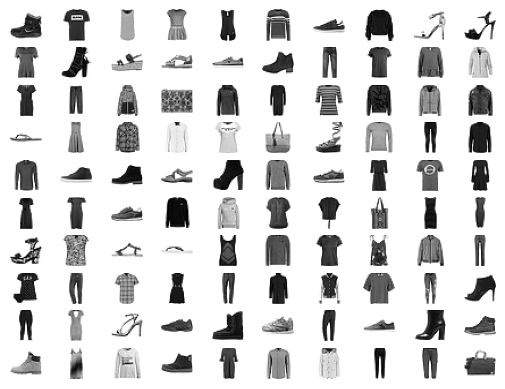

In [5]:
from keras.datasets.fashion_mnist import load_data
from matplotlib import pyplot
# load the images into memory
(trainX, trainy), (testX, testy) = load_data()
# plot images from the training dataset
for i in range(100):
 # define subplot
 pyplot.subplot(10, 10, 1 + i)
 # turn off axis
 pyplot.axis('off')
 # plot raw pixel data
 pyplot.imshow(trainX[i], cmap='gray_r')
pyplot.show()

Model: "model_3"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_8 (InputLayer)           [(None, 28, 28, 1)]  0           []                               
                                                                                                  
 conv2d_12 (Conv2D)             (None, 14, 14, 32)   320         ['input_8[0][0]']                
                                                                                                  
 leaky_re_lu_12 (LeakyReLU)     (None, 14, 14, 32)   0           ['conv2d_12[0][0]']              
                                                                                                  
 dropout_12 (Dropout)           (None, 14, 14, 32)   0           ['leaky_re_lu_12[0][0]']         
                                                                                            

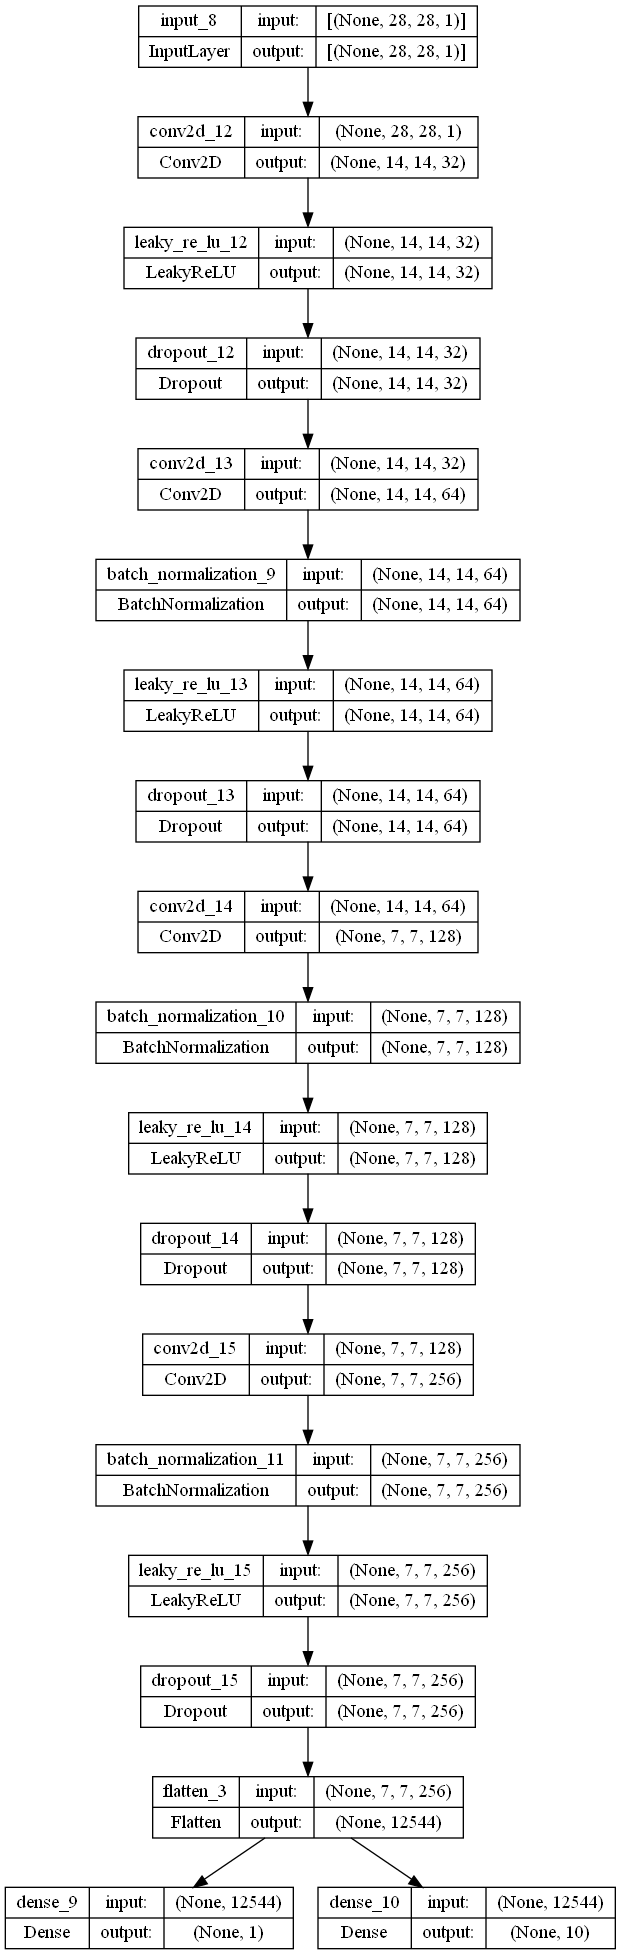

In [15]:
# example of defining the discriminator model
 
# define the standalone discriminator model
def define_discriminator(in_shape=(28,28,1), n_classes=10):
 # weight initialization
 init = RandomNormal(stddev=0.02)
 # image input
 in_image = Input(shape=in_shape)
 # downsample to 14x14
 fe = Conv2D(32, (3,3), strides=(2,2), padding='same', kernel_initializer=init)(in_image)
 fe = LeakyReLU(alpha=0.2)(fe)
 fe = Dropout(0.5)(fe)
 # normal
 fe = Conv2D(64, (3,3), padding='same', kernel_initializer=init)(fe)
 fe = BatchNormalization()(fe)
 fe = LeakyReLU(alpha=0.2)(fe)
 fe = Dropout(0.5)(fe)
 # downsample to 7x7
 fe = Conv2D(128, (3,3), strides=(2,2), padding='same', kernel_initializer=init)(fe)
 fe = BatchNormalization()(fe)
 fe = LeakyReLU(alpha=0.2)(fe)
 fe = Dropout(0.5)(fe)
 # normal
 fe = Conv2D(256, (3,3), padding='same', kernel_initializer=init)(fe)
 fe = BatchNormalization()(fe)
 fe = LeakyReLU(alpha=0.2)(fe)
 fe = Dropout(0.5)(fe)
 # flatten feature maps
 fe = Flatten()(fe)
 # real/fake output
 out1 = Dense(1, activation='sigmoid')(fe)
 # class label output
 out2 = Dense(n_classes, activation='softmax')(fe)
 # define model
 model = Model(in_image, [out1, out2])
 # compile model
 opt = Adam(lr=0.0002, beta_1=0.5)
 model.compile(loss=['binary_crossentropy', 'sparse_categorical_crossentropy'], optimizer=opt)
 return model
 
# define the discriminator model
model = define_discriminator()
# summarize the model
model.summary()
# plot the model
plot_model(model, to_file='discriminator_plot.png', show_shapes=True, show_layer_names=True)

Model: "model_4"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_12 (InputLayer)          [(None, 100)]        0           []                               
                                                                                                  
 input_11 (InputLayer)          [(None, 1)]          0           []                               
                                                                                                  
 dense_14 (Dense)               (None, 18816)        1900416     ['input_12[0][0]']               
                                                                                                  
 embedding_3 (Embedding)        (None, 1, 50)        500         ['input_11[0][0]']               
                                                                                            

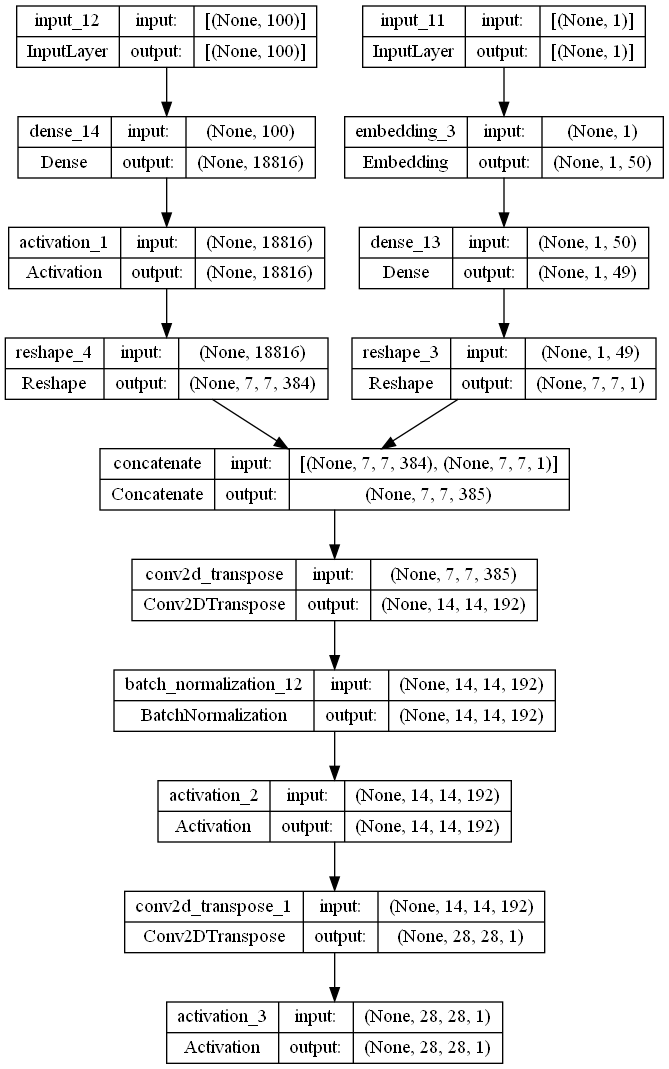

In [19]:
def define_generator(latent_dim, n_classes=10):
 # weight initialization
 init = RandomNormal(stddev=0.02)
 # label input
 in_label = Input(shape=(1,))
 # embedding for categorical input
 li = Embedding(n_classes, 50)(in_label)
 # linear multiplication
 n_nodes = 7 * 7
 li = Dense(n_nodes, kernel_initializer=init)(li)
 # reshape to additional channel
 li = Reshape((7, 7, 1))(li)
 # image generator input
 in_lat = Input(shape=(latent_dim,))
 # foundation for 7x7 image
 n_nodes = 384 * 7 * 7
 gen = Dense(n_nodes, kernel_initializer=init)(in_lat)
 gen = Activation('relu')(gen)
 gen = Reshape((7, 7, 384))(gen)
 # merge image gen and label input
 merge = Concatenate()([gen, li])
 # upsample to 14x14
 gen = Conv2DTranspose(192, (5,5), strides=(2,2), padding='same', kernel_initializer=init)(merge)
 gen = BatchNormalization()(gen)
 gen = Activation('relu')(gen)
 # upsample to 28x28
 gen = Conv2DTranspose(1, (5,5), strides=(2,2), padding='same', kernel_initializer=init)(gen)
 out_layer = Activation('tanh')(gen)
 # define model
 model = Model([in_lat, in_label], out_layer)
 return model

# define the size of the latent space
latent_dim = 100
# define the generator model
model = define_generator(latent_dim)
# summarize the model
model.summary()
# plot the model
plot_model(model, to_file='generator_plot.png', show_shapes=True, show_layer_names=True)

## Definición de la arquitectura GAN

Ya disponemos de una red generadora y otra discriminadora. Ahora, antes de realizar la composición del modelo completo, compilaremos el discriminador para luego impedir el entrenamiento de sus pesos en el resto del modelo, solo invocando su grafo explícitamente.

In [21]:
# define the combined generator and discriminator model, for updating the generator
def define_gan(g_model, d_model):
 # make weights in the discriminator not trainable
 for layer in d_model.layers:
   if not isinstance(layer, BatchNormalization):
     layer.trainable = False
 # connect the outputs of the generator to the inputs of the discriminator
 gan_output = d_model(g_model.output)
 # define gan model as taking noise and label and outputting real/fake and label outputs
 model = Model(g_model.input, gan_output)
 # compile model
 opt = Adam(lr=0.0002, beta_1=0.5)
 model.compile(loss=['binary_crossentropy', 'sparse_categorical_crossentropy'], optimizer=opt)
 return model

## Entrenamiento del modelo GAN

Ahora sí, podemos proceder al entrenamiento. A modo de resumen, el proceso es el siguiente:

1. Definimos el generador y discriminador, y los unimos en un único modelo.
2. Cargamos datos reales.
3. Entrenamos la red, en un bucle. Antes de todo calculamos el número de batches y pasos a realizar - que son 64 y 100 por defecto, respectivamente.
* 3.1 Tomará medio batch de imágenes reales $\mathcal{R}$, que se indican verdaderas.
* 3.2 Entrenará al discriminador con las muestras auténticas para reconocerlas.
* 3.3 Pedirá al generador crear medio batch de imágenes ficticias $\mathcal{F}$, que se indican adecuadamente como falsas.
* 3.4 Entrenará al discriminador con las muestras falsas para reconocerlas.
* 3.5 Ahora se pedirá al generador crear nuevas muestras falsas $\mathcal{F}$, pero diciendo que son verdaderas.
* 3.6 Se mandan esas muestras a la red GAN entera para entrenarla según el error que de el discriminador - como hemos dicho antes, hemos hecho el discriminador no entrenable cuando está en la GAN así que esto solo entrena al generador.
4. Para hacernos la vida más fácil, cada cierto número de pasos se nos indica como va, y se guarda.

In [23]:
#Cargar imágenes
def load_real_samples():
 # load dataset
 (trainX, trainy), (_, _) = load_data()
 # expand to 3d, e.g. add channels
 X = expand_dims(trainX, axis=-1)
 # convert from ints to floats
 X = X.astype('float32')
 # scale from [0,255] to [-1,1]
 X = (X - 127.5) / 127.5
 print(X.shape, trainy.shape)
 return [X, trainy]

In [24]:
# select real samples
def generate_real_samples(dataset, n_samples):
 # split into images and labels
 images, labels = dataset
 # choose random instances
 ix = randint(0, images.shape[0], n_samples)
 # select images and labels
 X, labels = images[ix], labels[ix]
 # generate class labels
 y = ones((n_samples, 1))
 return [X, labels], y

In [47]:
# generate points in latent space as input for the generator
def generate_latent_points(latent_dim, n_samples, n_classes=10):
 # generate points in the latent space
 x_input = randn(latent_dim * n_samples)
 # reshape into a batch of inputs for the network
 z_input = x_input.reshape(n_samples, latent_dim)
 # generate labels
 labels = randint(0, n_classes, n_samples)
 return [z_input, labels]

In [44]:
# use the generator to generate n fake examples, with class labels
def generate_fake_samples(generator, latent_dim, n_samples):
 # generate points in latent space
 z_input, labels_input = generate_latent_points(latent_dim, n_samples)
 # predict outputs
 images = generator.predict([z_input, labels_input])
 # create class labels
 y = zeros((n_samples, 1))
 return [images, labels_input], y

In [29]:
# generate samples and save as a plot and save the model
def summarize_performance(step, g_model, latent_dim, n_samples=100):
 # prepare fake examples
 [X, _], _ = generate_fake_samples(g_model, latent_dim, n_samples)
 # scale from [-1,1] to [0,1]
 X = (X + 1) / 2.0
 # plot images
 for i in range(100):
 # define subplot
   plt.subplot(10, 10, 1 + i)
   # turn off axis
   pyplot.axis('off')
   # plot raw pixel data
   plt.imshow(X[i, :, :, 0], cmap='gray_r')
 # save plot to file
 filename1 = 'generated_plot_%04d.png' % (step+1)
 plt.savefig(filename1)
 pyplot.close()
 # save the generator model
 filename2 = 'model_%04d.h5' % (step+1)
 g_model.save(filename2)
 print('>Saved: %s and %s' % (filename1, filename2))

In [55]:
# train the generator and discriminator
def train(g_model, d_model, gan_model, dataset, latent_dim, n_epochs=100, n_batch=64):
 # calculate the number of batches per training epoch
 bat_per_epo = int(dataset[0].shape[0] / n_batch)
 # calculate the number of training iterations
 n_steps = bat_per_epo * n_epochs
 print(n_steps)
 # calculate the size of half a batch of samples
 half_batch = int(n_batch / 2)
 # manually enumerate epochs
 for i in range(n_steps):
   # get randomly selected 'real' samples
   [X_real, labels_real], y_real = generate_real_samples(dataset, half_batch)
   # update discriminator model weights
   _,d_r1,d_r2 = d_model.train_on_batch(X_real, [y_real, labels_real])
   # generate 'fake' examples
   [X_fake, labels_fake], y_fake = generate_fake_samples(g_model, latent_dim, half_batch)
   # update discriminator model weights
   _,d_f,d_f2 = d_model.train_on_batch(X_fake, [y_fake, labels_fake])
   # prepare points in latent space as input for the generator
   [z_input, z_labels] = generate_latent_points(latent_dim, n_batch)
   # create inverted labels for the fake samples
   y_gan = ones((n_batch, 1))
   # update the generator via the discriminator's error
   _,g_1,g_2 = gan_model.train_on_batch([z_input, z_labels], [y_gan, z_labels])
   # summarize loss on this batch
   #print(i)
   print('>%d, dr[%.3f,%.3f], df[%.3f,%.3f], g[%.3f,%.3f]' % (i+1, d_r1,d_r2, d_f,d_f2, g_1,g_2))
   # evaluate the model performance every 'epoch'
   if (i+1) % (bat_per_epo * 10) == 0:
     summarize_performance(i, g_model, latent_dim)

In [56]:
# size of the latent space
latent_dim = 100
# create the discriminator
discriminator = define_discriminator()
# create the generator
generator = define_generator(latent_dim)
# create the gan
gan_model = define_gan(generator, discriminator)
# load image data
dataset = load_real_samples()
# train model
train(generator, discriminator, gan_model, dataset, latent_dim)

(60000, 28, 28, 1) (60000,)
93700
1/1 [==============================] - 0s 154ms/step
>1, dr[1.049,3.048], df[1.475,3.463], g[0.694,3.245]
1/1 [==============================] - 0s 98ms/step
>2, dr[0.610,3.337], df[1.193,2.922], g[0.729,2.980]
1/1 [==============================] - 0s 94ms/step
>3, dr[0.471,3.256], df[0.926,3.059], g[0.896,3.087]
1/1 [==============================] - 0s 97ms/step
>4, dr[0.642,3.062], df[0.868,2.658], g[1.050,2.926]
1/1 [==============================] - 0s 95ms/step
>5, dr[0.704,2.698], df[0.770,2.995], g[1.281,3.163]
1/1 [==============================] - 0s 99ms/step
>6, dr[0.974,2.974], df[0.836,3.295], g[0.981,3.416]
1/1 [==============================] - 0s 97ms/step
>7, dr[0.669,2.817], df[0.722,2.945], g[1.256,2.988]
1/1 [==============================] - 0s 97ms/step
>8, dr[0.731,2.371], df[0.586,3.115], g[1.132,3.089]
1/1 [==============================] - 0s 99ms/step
>9, dr[0.577,2.648], df[0.724,2.915], g[1.341,3.141]
1/1 [===============

1/1 [==============================] - 0s 104ms/step
>78, dr[0.077,1.003], df[0.111,2.615], g[0.071,2.723]
1/1 [==============================] - 0s 100ms/step
>79, dr[0.190,1.312], df[0.088,2.782], g[0.041,2.934]
1/1 [==============================] - 0s 98ms/step
>80, dr[0.058,1.278], df[0.115,3.182], g[0.051,2.796]
1/1 [==============================] - 0s 103ms/step
>81, dr[0.123,1.109], df[0.120,2.991], g[0.056,3.036]
1/1 [==============================] - 0s 101ms/step
>82, dr[0.072,0.863], df[0.092,3.111], g[0.077,2.752]
1/1 [==============================] - 0s 98ms/step
>83, dr[0.072,1.332], df[0.057,2.675], g[0.084,3.018]
1/1 [==============================] - 0s 100ms/step
>84, dr[0.073,1.352], df[0.060,2.870], g[0.084,2.998]
1/1 [==============================] - 0s 100ms/step
>85, dr[0.087,1.220], df[0.060,2.906], g[0.095,2.791]
1/1 [==============================] - 0s 101ms/step
>86, dr[0.149,1.048], df[0.111,2.630], g[0.097,3.134]
1/1 [==============================] - 

>154, dr[0.060,0.868], df[0.015,0.756], g[0.070,0.411]
1/1 [==============================] - 0s 100ms/step
>155, dr[0.059,0.912], df[0.062,0.685], g[0.022,0.328]
1/1 [==============================] - 0s 101ms/step
>156, dr[0.191,1.238], df[0.050,0.370], g[0.014,0.321]
1/1 [==============================] - 0s 100ms/step
>157, dr[0.098,1.009], df[0.058,0.330], g[0.007,0.346]
1/1 [==============================] - 0s 98ms/step
>158, dr[0.048,0.836], df[0.067,0.438], g[0.012,0.252]
1/1 [==============================] - 0s 102ms/step
>159, dr[0.039,0.960], df[0.049,0.409], g[0.014,0.349]
1/1 [==============================] - 0s 101ms/step
>160, dr[0.074,1.513], df[0.041,0.435], g[0.033,0.254]
1/1 [==============================] - 0s 99ms/step
>161, dr[0.030,0.790], df[0.073,0.514], g[0.027,0.305]
1/1 [==============================] - 0s 103ms/step
>162, dr[0.021,0.551], df[0.028,0.320], g[0.021,0.270]
1/1 [==============================] - 0s 99ms/step
>163, dr[0.027,0.851], df[0.028

1/1 [==============================] - 0s 97ms/step
>231, dr[0.029,1.422], df[0.011,0.077], g[0.008,0.080]
1/1 [==============================] - 0s 99ms/step
>232, dr[0.026,0.850], df[0.072,0.064], g[0.051,0.088]
1/1 [==============================] - 0s 98ms/step
>233, dr[0.017,0.603], df[0.003,0.150], g[0.039,0.091]
1/1 [==============================] - 0s 98ms/step
>234, dr[0.018,1.357], df[0.019,0.171], g[0.036,0.094]
1/1 [==============================] - 0s 98ms/step
>235, dr[0.033,1.588], df[0.052,0.133], g[0.023,0.075]
1/1 [==============================] - 0s 98ms/step
>236, dr[0.025,0.972], df[0.019,0.039], g[0.082,0.062]
1/1 [==============================] - 0s 99ms/step
>237, dr[0.028,0.881], df[0.016,0.062], g[0.037,0.138]
1/1 [==============================] - 0s 101ms/step
>238, dr[0.073,0.730], df[0.010,0.093], g[0.023,0.127]
1/1 [==============================] - 0s 99ms/step
>239, dr[0.035,0.924], df[0.093,0.127], g[0.029,0.092]
1/1 [==============================]

1/1 [==============================] - 0s 101ms/step
>307, dr[0.059,1.170], df[0.057,0.111], g[0.161,0.094]
1/1 [==============================] - 0s 100ms/step
>308, dr[0.038,0.790], df[0.084,0.069], g[0.411,0.120]
1/1 [==============================] - 0s 96ms/step
>309, dr[0.073,0.602], df[0.087,0.087], g[0.278,0.151]
1/1 [==============================] - 0s 101ms/step
>310, dr[0.254,1.010], df[0.208,0.065], g[0.140,0.205]
1/1 [==============================] - 0s 98ms/step
>311, dr[0.035,0.732], df[0.157,0.045], g[0.320,0.065]
1/1 [==============================] - 0s 98ms/step
>312, dr[0.082,1.214], df[0.028,0.029], g[0.452,0.118]
1/1 [==============================] - 0s 99ms/step
>313, dr[0.322,0.745], df[0.697,0.083], g[8.383,0.284]
1/1 [==============================] - 0s 100ms/step
>314, dr[1.888,0.953], df[0.129,0.150], g[1.103,0.245]
1/1 [==============================] - 0s 97ms/step
>315, dr[0.115,1.170], df[0.559,0.115], g[5.532,0.166]
1/1 [============================

1/1 [==============================] - 0s 101ms/step
>383, dr[0.710,0.436], df[0.888,0.058], g[1.404,0.041]
1/1 [==============================] - 0s 104ms/step
>384, dr[0.834,1.203], df[0.892,0.068], g[1.998,0.099]
1/1 [==============================] - 0s 100ms/step
>385, dr[0.709,0.626], df[0.539,0.049], g[1.983,0.073]
1/1 [==============================] - 0s 99ms/step
>386, dr[0.828,0.939], df[0.694,0.048], g[1.634,0.042]
1/1 [==============================] - 0s 99ms/step
>387, dr[0.591,0.333], df[0.910,0.064], g[1.837,0.051]
1/1 [==============================] - 0s 99ms/step
>388, dr[0.679,0.763], df[0.519,0.018], g[1.960,0.066]
1/1 [==============================] - 0s 103ms/step
>389, dr[0.601,0.863], df[0.500,0.017], g[1.549,0.044]
1/1 [==============================] - 0s 98ms/step
>390, dr[0.499,0.834], df[0.647,0.066], g[1.461,0.039]
1/1 [==============================] - 0s 99ms/step
>391, dr[0.644,0.806], df[0.543,0.044], g[1.674,0.040]
1/1 [============================

1/1 [==============================] - 0s 100ms/step
>459, dr[0.441,0.799], df[0.445,0.041], g[1.366,0.051]
1/1 [==============================] - 0s 104ms/step
>460, dr[0.817,0.430], df[0.679,0.025], g[1.296,0.046]
1/1 [==============================] - 0s 106ms/step
>461, dr[0.529,0.719], df[0.977,0.054], g[1.866,0.048]
1/1 [==============================] - 0s 99ms/step
>462, dr[0.946,0.672], df[0.744,0.123], g[1.956,0.039]
1/1 [==============================] - 0s 101ms/step
>463, dr[0.811,1.193], df[1.108,0.089], g[1.702,0.035]
1/1 [==============================] - 0s 103ms/step
>464, dr[0.947,1.307], df[1.233,0.410], g[1.956,0.056]
1/1 [==============================] - 0s 101ms/step
>465, dr[0.597,0.515], df[0.599,0.288], g[2.721,0.069]
1/1 [==============================] - 0s 100ms/step
>466, dr[0.604,0.905], df[0.120,0.412], g[2.534,0.056]
1/1 [==============================] - 0s 99ms/step
>467, dr[0.781,0.496], df[0.203,0.346], g[1.895,0.088]
1/1 [=========================

1/1 [==============================] - 0s 99ms/step
>535, dr[0.317,0.797], df[0.210,0.127], g[2.381,0.042]
1/1 [==============================] - 0s 101ms/step
>536, dr[0.414,0.708], df[0.313,0.084], g[1.954,0.058]
1/1 [==============================] - 0s 99ms/step
>537, dr[0.270,0.845], df[0.392,0.143], g[2.277,0.077]
1/1 [==============================] - 0s 101ms/step
>538, dr[0.364,0.533], df[0.683,0.104], g[2.152,0.112]
1/1 [==============================] - 0s 100ms/step
>539, dr[0.515,0.528], df[0.468,0.072], g[2.437,0.157]
1/1 [==============================] - 0s 100ms/step
>540, dr[0.384,1.213], df[0.415,0.127], g[2.091,0.137]
1/1 [==============================] - 0s 98ms/step
>541, dr[0.502,0.625], df[0.322,0.246], g[2.260,0.120]
1/1 [==============================] - 0s 102ms/step
>542, dr[0.621,0.959], df[0.401,0.255], g[1.667,0.130]
1/1 [==============================] - 0s 99ms/step
>543, dr[0.613,1.171], df[0.455,0.096], g[2.093,0.104]
1/1 [===========================

1/1 [==============================] - 0s 100ms/step
>611, dr[0.498,1.045], df[0.343,0.098], g[1.528,0.095]
1/1 [==============================] - 0s 105ms/step
>612, dr[0.334,0.872], df[0.549,0.079], g[1.966,0.103]
1/1 [==============================] - 0s 101ms/step
>613, dr[0.317,1.163], df[0.450,0.093], g[2.091,0.162]
1/1 [==============================] - 0s 101ms/step
>614, dr[0.497,0.595], df[0.436,0.260], g[2.081,0.090]
1/1 [==============================] - 0s 101ms/step
>615, dr[0.692,0.572], df[0.652,0.064], g[1.959,0.143]
1/1 [==============================] - 0s 102ms/step
>616, dr[0.318,0.878], df[0.408,0.056], g[2.114,0.169]
1/1 [==============================] - 0s 100ms/step
>617, dr[0.357,0.781], df[0.447,0.137], g[2.434,0.144]
1/1 [==============================] - 0s 100ms/step
>618, dr[0.315,0.600], df[0.278,0.063], g[2.616,0.094]
1/1 [==============================] - 0s 100ms/step
>619, dr[0.478,1.347], df[0.472,0.042], g[2.345,0.185]
1/1 [=======================

1/1 [==============================] - 0s 102ms/step
>687, dr[0.411,0.907], df[0.137,0.036], g[2.991,0.086]
1/1 [==============================] - 0s 101ms/step
>688, dr[0.257,0.474], df[0.146,0.030], g[3.413,0.066]
1/1 [==============================] - 0s 102ms/step
>689, dr[0.159,0.960], df[0.168,0.053], g[3.491,0.072]
1/1 [==============================] - 0s 100ms/step
>690, dr[0.204,1.261], df[0.131,0.051], g[2.978,0.035]
1/1 [==============================] - 0s 103ms/step
>691, dr[0.202,0.574], df[0.180,0.045], g[3.443,0.124]
1/1 [==============================] - 0s 100ms/step
>692, dr[0.136,0.636], df[0.162,0.057], g[3.255,0.112]
1/1 [==============================] - 0s 102ms/step
>693, dr[0.243,1.535], df[0.164,0.123], g[3.001,0.094]
1/1 [==============================] - 0s 101ms/step
>694, dr[0.188,0.812], df[0.081,0.124], g[2.920,0.073]
1/1 [==============================] - 0s 104ms/step
>695, dr[0.173,1.086], df[0.115,0.116], g[2.846,0.112]
1/1 [=======================

1/1 [==============================] - 0s 102ms/step
>763, dr[0.221,0.917], df[0.279,0.025], g[2.074,0.078]
1/1 [==============================] - 0s 103ms/step
>764, dr[0.359,0.487], df[0.224,0.090], g[2.007,0.212]
1/1 [==============================] - 0s 107ms/step
>765, dr[0.533,0.777], df[0.332,0.155], g[1.957,0.094]
1/1 [==============================] - 0s 104ms/step
>766, dr[0.269,0.776], df[0.264,0.131], g[1.637,0.171]
1/1 [==============================] - 0s 109ms/step
>767, dr[0.397,0.612], df[0.363,0.123], g[1.686,0.112]
1/1 [==============================] - 0s 108ms/step
>768, dr[0.318,1.055], df[0.312,0.170], g[2.123,0.053]
1/1 [==============================] - 0s 104ms/step
>769, dr[0.253,0.334], df[0.217,0.055], g[1.821,0.191]
1/1 [==============================] - 0s 103ms/step
>770, dr[0.486,1.061], df[0.254,0.037], g[1.767,0.265]
1/1 [==============================] - 0s 106ms/step
>771, dr[0.406,0.213], df[0.452,0.079], g[2.284,0.155]
1/1 [=======================

1/1 [==============================] - 0s 104ms/step
>839, dr[0.410,1.238], df[0.466,0.074], g[2.003,0.040]
1/1 [==============================] - 0s 104ms/step
>840, dr[0.403,0.587], df[0.621,0.135], g[2.339,0.096]
1/1 [==============================] - 0s 110ms/step
>841, dr[0.367,1.317], df[0.264,0.104], g[2.797,0.157]
1/1 [==============================] - 0s 104ms/step
>842, dr[0.482,0.880], df[0.441,0.215], g[3.203,0.080]
1/1 [==============================] - 0s 108ms/step
>843, dr[0.879,0.725], df[0.416,0.167], g[2.653,0.195]
1/1 [==============================] - 0s 113ms/step
>844, dr[0.733,0.805], df[0.374,0.202], g[1.874,0.065]
1/1 [==============================] - 0s 106ms/step
>845, dr[0.626,1.677], df[0.691,0.124], g[1.634,0.080]
1/1 [==============================] - 0s 106ms/step
>846, dr[0.257,0.704], df[0.494,0.027], g[2.036,0.164]
1/1 [==============================] - 0s 110ms/step
>847, dr[0.207,0.488], df[0.360,0.073], g[2.200,0.134]
1/1 [=======================

1/1 [==============================] - 0s 108ms/step
>915, dr[0.346,0.247], df[0.298,0.129], g[1.620,0.045]
1/1 [==============================] - 0s 108ms/step
>916, dr[0.298,0.595], df[0.495,0.096], g[1.526,0.056]
1/1 [==============================] - 0s 112ms/step
>917, dr[0.365,0.421], df[0.222,0.084], g[1.522,0.063]
1/1 [==============================] - 0s 111ms/step
>918, dr[0.112,0.746], df[0.351,0.019], g[1.477,0.070]
1/1 [==============================] - 0s 106ms/step
>919, dr[0.230,0.627], df[0.277,0.065], g[2.008,0.098]
1/1 [==============================] - 0s 114ms/step
>920, dr[0.660,1.615], df[0.460,0.036], g[1.765,0.060]
1/1 [==============================] - 0s 106ms/step
>921, dr[0.414,0.695], df[0.404,0.037], g[1.377,0.059]
1/1 [==============================] - 0s 110ms/step
>922, dr[0.329,0.627], df[0.377,0.088], g[1.945,0.065]
1/1 [==============================] - 0s 110ms/step
>923, dr[0.342,1.120], df[0.403,0.123], g[2.511,0.072]
1/1 [=======================

1/1 [==============================] - 0s 112ms/step
>991, dr[0.236,1.346], df[0.526,0.114], g[1.875,0.106]
1/1 [==============================] - 0s 107ms/step
>992, dr[0.401,0.550], df[0.243,0.158], g[1.332,0.115]
1/1 [==============================] - 0s 107ms/step
>993, dr[0.551,0.633], df[0.264,0.222], g[1.508,0.143]
1/1 [==============================] - 0s 110ms/step
>994, dr[0.632,0.716], df[0.462,0.145], g[1.210,0.194]
1/1 [==============================] - 0s 105ms/step
>995, dr[0.235,1.186], df[0.466,0.049], g[1.677,0.183]
1/1 [==============================] - 0s 107ms/step
>996, dr[0.597,1.014], df[0.218,0.070], g[1.639,0.109]
1/1 [==============================] - 0s 110ms/step
>997, dr[0.173,0.429], df[0.409,0.115], g[2.355,0.135]
1/1 [==============================] - 0s 105ms/step
>998, dr[0.292,0.785], df[0.310,0.192], g[2.566,0.177]
1/1 [==============================] - 0s 108ms/step
>999, dr[0.381,0.229], df[0.166,0.043], g[2.325,0.109]
1/1 [=======================

1/1 [==============================] - 0s 105ms/step
>1066, dr[0.728,0.921], df[0.461,0.116], g[2.039,0.119]
1/1 [==============================] - 0s 105ms/step
>1067, dr[0.829,0.471], df[0.499,0.092], g[1.648,0.154]
1/1 [==============================] - 0s 132ms/step
>1068, dr[0.527,0.627], df[0.586,0.198], g[1.749,0.084]
1/1 [==============================] - 0s 110ms/step
>1069, dr[0.441,0.328], df[0.403,0.157], g[2.152,0.143]
1/1 [==============================] - 0s 118ms/step
>1070, dr[0.541,0.938], df[0.497,0.083], g[2.407,0.135]
1/1 [==============================] - 0s 112ms/step
>1071, dr[0.555,0.649], df[0.497,0.149], g[2.099,0.077]
1/1 [==============================] - 0s 109ms/step
>1072, dr[0.533,0.422], df[0.852,0.131], g[1.533,0.097]
1/1 [==============================] - 0s 110ms/step
>1073, dr[0.644,0.836], df[0.833,0.055], g[1.814,0.184]
1/1 [==============================] - 0s 116ms/step
>1074, dr[0.554,0.505], df[0.881,0.112], g[2.270,0.202]
1/1 [==============

1/1 [==============================] - 0s 107ms/step
>1141, dr[0.486,0.731], df[0.396,0.107], g[2.155,0.086]
1/1 [==============================] - 0s 108ms/step
>1142, dr[0.386,0.372], df[0.593,0.231], g[2.351,0.113]
1/1 [==============================] - 0s 107ms/step
>1143, dr[0.482,0.755], df[0.435,0.156], g[2.532,0.198]
1/1 [==============================] - 0s 107ms/step
>1144, dr[0.838,0.415], df[0.454,0.117], g[1.857,0.199]
1/1 [==============================] - 0s 108ms/step
>1145, dr[0.598,0.849], df[0.715,0.106], g[2.128,0.259]
1/1 [==============================] - 0s 108ms/step
>1146, dr[0.406,1.403], df[0.417,0.121], g[1.809,0.232]
1/1 [==============================] - 0s 107ms/step
>1147, dr[0.603,1.333], df[0.550,0.136], g[1.729,0.173]
1/1 [==============================] - 0s 106ms/step
>1148, dr[0.427,0.245], df[0.595,0.321], g[1.330,0.353]
1/1 [==============================] - 0s 106ms/step
>1149, dr[0.600,0.602], df[0.467,0.149], g[1.574,0.148]
1/1 [==============

1/1 [==============================] - 0s 111ms/step
>1216, dr[1.069,0.259], df[0.331,0.046], g[1.547,0.164]
1/1 [==============================] - 0s 109ms/step
>1217, dr[0.228,0.875], df[0.749,0.030], g[1.908,0.103]
1/1 [==============================] - 0s 111ms/step
>1218, dr[0.287,0.304], df[0.527,0.299], g[2.896,0.132]
1/1 [==============================] - 0s 109ms/step
>1219, dr[0.853,0.928], df[0.674,0.181], g[1.971,0.064]
1/1 [==============================] - 0s 108ms/step
>1220, dr[0.525,0.632], df[0.531,0.072], g[2.164,0.130]
1/1 [==============================] - 0s 106ms/step
>1221, dr[1.001,0.703], df[0.677,0.239], g[1.636,0.076]
1/1 [==============================] - 0s 109ms/step
>1222, dr[0.406,0.991], df[0.658,0.083], g[1.984,0.136]
1/1 [==============================] - 0s 109ms/step
>1223, dr[0.631,0.640], df[0.699,0.148], g[1.907,0.091]
1/1 [==============================] - 0s 107ms/step
>1224, dr[0.230,0.682], df[0.297,0.159], g[2.229,0.119]
1/1 [==============

1/1 [==============================] - 0s 109ms/step
>1291, dr[0.391,0.434], df[0.490,0.084], g[2.224,0.130]
1/1 [==============================] - 0s 115ms/step
>1292, dr[0.543,0.833], df[0.430,0.115], g[2.072,0.130]
1/1 [==============================] - 0s 109ms/step
>1293, dr[0.557,0.744], df[0.773,0.152], g[2.061,0.042]
1/1 [==============================] - 0s 109ms/step
>1294, dr[0.530,0.740], df[0.474,0.062], g[2.134,0.025]
1/1 [==============================] - 0s 114ms/step
>1295, dr[0.381,0.783], df[0.490,0.066], g[2.113,0.099]
1/1 [==============================] - 0s 108ms/step
>1296, dr[0.393,0.496], df[0.528,0.099], g[2.285,0.075]
1/1 [==============================] - 0s 108ms/step
>1297, dr[0.651,0.453], df[0.330,0.118], g[2.160,0.052]
1/1 [==============================] - 0s 111ms/step
>1298, dr[0.543,0.544], df[0.433,0.102], g[1.854,0.069]
1/1 [==============================] - 0s 109ms/step
>1299, dr[0.411,0.428], df[0.459,0.108], g[1.847,0.043]
1/1 [==============

1/1 [==============================] - 0s 110ms/step
>1366, dr[0.340,0.398], df[0.227,0.059], g[1.586,0.103]
1/1 [==============================] - 0s 109ms/step
>1367, dr[0.511,0.819], df[0.488,0.041], g[1.740,0.095]
1/1 [==============================] - 0s 109ms/step
>1368, dr[0.264,0.475], df[0.241,0.070], g[1.585,0.085]
1/1 [==============================] - 0s 114ms/step
>1369, dr[0.341,0.441], df[0.399,0.123], g[1.743,0.071]
1/1 [==============================] - 0s 108ms/step
>1370, dr[0.566,1.054], df[0.394,0.101], g[1.724,0.137]
1/1 [==============================] - 0s 111ms/step
>1371, dr[0.262,0.502], df[0.574,0.049], g[2.273,0.101]
1/1 [==============================] - 0s 114ms/step
>1372, dr[0.310,0.565], df[0.266,0.154], g[2.266,0.121]
1/1 [==============================] - 0s 111ms/step
>1373, dr[0.476,0.603], df[0.277,0.029], g[1.871,0.080]
1/1 [==============================] - 0s 112ms/step
>1374, dr[0.439,0.781], df[0.349,0.091], g[1.583,0.074]
1/1 [==============

1/1 [==============================] - 0s 115ms/step
>1441, dr[0.472,0.484], df[0.504,0.071], g[1.809,0.178]
1/1 [==============================] - 0s 109ms/step
>1442, dr[0.261,0.699], df[0.538,0.317], g[2.381,0.108]
1/1 [==============================] - 0s 106ms/step
>1443, dr[0.535,0.490], df[0.182,0.078], g[2.227,0.179]
1/1 [==============================] - 0s 110ms/step
>1444, dr[0.414,0.446], df[0.511,0.113], g[1.839,0.148]
1/1 [==============================] - 0s 107ms/step
>1445, dr[0.289,1.135], df[0.578,0.029], g[2.196,0.154]
1/1 [==============================] - 0s 110ms/step
>1446, dr[0.675,0.676], df[0.485,0.155], g[2.377,0.040]
1/1 [==============================] - 0s 109ms/step
>1447, dr[0.629,0.642], df[0.551,0.120], g[1.812,0.140]
1/1 [==============================] - 0s 109ms/step
>1448, dr[0.363,0.538], df[0.325,0.110], g[1.815,0.103]
1/1 [==============================] - 0s 107ms/step
>1449, dr[0.425,0.756], df[0.426,0.086], g[2.189,0.161]
1/1 [==============

1/1 [==============================] - 0s 113ms/step
>1516, dr[0.357,0.623], df[0.563,0.092], g[1.924,0.151]
1/1 [==============================] - 0s 109ms/step
>1517, dr[0.491,0.783], df[0.566,0.323], g[1.791,0.144]
1/1 [==============================] - 0s 110ms/step
>1518, dr[0.415,0.541], df[0.505,0.101], g[2.331,0.112]
1/1 [==============================] - 0s 109ms/step
>1519, dr[0.443,0.579], df[0.414,0.119], g[2.351,0.172]
1/1 [==============================] - 0s 109ms/step
>1520, dr[0.469,0.560], df[0.395,0.112], g[2.236,0.175]
1/1 [==============================] - 0s 110ms/step
>1521, dr[0.429,0.774], df[0.404,0.243], g[1.667,0.098]
1/1 [==============================] - 0s 109ms/step
>1522, dr[0.249,1.040], df[0.547,0.075], g[1.834,0.139]
1/1 [==============================] - 0s 109ms/step
>1523, dr[0.327,0.468], df[0.464,0.178], g[1.907,0.088]
1/1 [==============================] - 0s 114ms/step
>1524, dr[0.489,0.815], df[0.330,0.105], g[2.331,0.155]
1/1 [==============

1/1 [==============================] - 0s 108ms/step
>1591, dr[0.547,0.456], df[0.577,0.113], g[2.113,0.079]
1/1 [==============================] - 0s 108ms/step
>1592, dr[0.499,1.233], df[0.357,0.201], g[1.493,0.134]
1/1 [==============================] - 0s 109ms/step
>1593, dr[0.392,0.923], df[0.511,0.106], g[1.899,0.137]
1/1 [==============================] - 0s 108ms/step
>1594, dr[0.479,0.820], df[0.534,0.116], g[1.818,0.095]
1/1 [==============================] - 0s 109ms/step
>1595, dr[0.415,0.397], df[0.360,0.037], g[1.753,0.080]
1/1 [==============================] - 0s 108ms/step
>1596, dr[0.588,0.650], df[0.556,0.140], g[1.590,0.128]
1/1 [==============================] - 0s 109ms/step
>1597, dr[0.233,0.438], df[0.351,0.078], g[2.091,0.141]
1/1 [==============================] - 0s 111ms/step
>1598, dr[0.503,0.393], df[0.346,0.097], g[1.864,0.180]
1/1 [==============================] - 0s 107ms/step
>1599, dr[0.364,0.525], df[0.683,0.205], g[1.884,0.084]
1/1 [==============

1/1 [==============================] - 0s 111ms/step
>1666, dr[0.308,0.550], df[0.248,0.098], g[2.294,0.073]
1/1 [==============================] - 0s 109ms/step
>1667, dr[0.725,0.641], df[0.429,0.087], g[1.943,0.138]
1/1 [==============================] - 0s 111ms/step
>1668, dr[0.335,0.613], df[0.344,0.114], g[1.966,0.236]
1/1 [==============================] - 0s 109ms/step
>1669, dr[0.225,0.753], df[0.496,0.158], g[2.153,0.068]
1/1 [==============================] - 0s 108ms/step
>1670, dr[0.406,0.925], df[0.232,0.206], g[1.829,0.068]
1/1 [==============================] - 0s 115ms/step
>1671, dr[0.382,0.613], df[0.519,0.081], g[1.614,0.125]
1/1 [==============================] - 0s 108ms/step
>1672, dr[0.525,1.448], df[0.398,0.072], g[1.499,0.178]
1/1 [==============================] - 0s 109ms/step
>1673, dr[0.444,1.121], df[0.367,0.038], g[1.683,0.093]
1/1 [==============================] - 0s 113ms/step
>1674, dr[0.355,0.417], df[0.571,0.091], g[1.848,0.086]
1/1 [==============

1/1 [==============================] - 0s 115ms/step
>1741, dr[0.454,1.283], df[0.483,0.024], g[1.750,0.135]
1/1 [==============================] - 0s 114ms/step
>1742, dr[0.246,0.544], df[0.480,0.074], g[1.841,0.101]
1/1 [==============================] - 0s 113ms/step
>1743, dr[0.593,0.679], df[0.624,0.135], g[1.414,0.127]
1/1 [==============================] - 0s 112ms/step
>1744, dr[0.437,0.521], df[0.528,0.111], g[1.815,0.098]
1/1 [==============================] - 0s 113ms/step
>1745, dr[0.294,0.453], df[0.275,0.175], g[2.015,0.272]
1/1 [==============================] - 0s 112ms/step
>1746, dr[0.503,0.476], df[0.513,0.163], g[2.004,0.151]
1/1 [==============================] - 0s 113ms/step
>1747, dr[0.483,0.773], df[0.530,0.280], g[2.123,0.160]
1/1 [==============================] - 0s 112ms/step
>1748, dr[0.595,0.687], df[0.361,0.060], g[1.644,0.084]
1/1 [==============================] - 0s 116ms/step
>1749, dr[0.380,0.456], df[0.522,0.143], g[2.066,0.146]
1/1 [==============

1/1 [==============================] - 0s 114ms/step
>1816, dr[0.659,0.587], df[0.518,0.057], g[1.801,0.110]
1/1 [==============================] - 0s 116ms/step
>1817, dr[0.537,0.920], df[0.430,0.090], g[1.667,0.204]
1/1 [==============================] - 0s 112ms/step
>1818, dr[0.428,0.531], df[0.610,0.070], g[1.822,0.147]
1/1 [==============================] - 0s 115ms/step
>1819, dr[0.821,0.625], df[0.481,0.131], g[1.400,0.176]
1/1 [==============================] - 0s 117ms/step
>1820, dr[0.412,0.356], df[0.433,0.120], g[1.556,0.078]
1/1 [==============================] - 0s 114ms/step
>1821, dr[0.406,0.485], df[0.441,0.150], g[1.540,0.153]
1/1 [==============================] - 0s 117ms/step
>1822, dr[0.427,0.502], df[0.361,0.073], g[1.771,0.180]
1/1 [==============================] - 0s 114ms/step
>1823, dr[0.388,0.532], df[0.530,0.083], g[2.048,0.121]
1/1 [==============================] - 0s 113ms/step
>1824, dr[0.291,0.679], df[0.397,0.041], g[2.265,0.058]
1/1 [==============

1/1 [==============================] - 0s 116ms/step
>1891, dr[0.363,0.955], df[0.455,0.114], g[2.405,0.093]
1/1 [==============================] - 0s 114ms/step
>1892, dr[0.324,0.363], df[0.213,0.106], g[2.251,0.103]
1/1 [==============================] - 0s 118ms/step
>1893, dr[0.322,0.467], df[0.356,0.055], g[1.878,0.057]
1/1 [==============================] - 0s 116ms/step
>1894, dr[0.417,0.457], df[0.313,0.088], g[1.931,0.082]
1/1 [==============================] - 0s 114ms/step
>1895, dr[0.481,0.495], df[0.478,0.373], g[1.563,0.208]
1/1 [==============================] - 0s 114ms/step
>1896, dr[0.286,0.418], df[0.414,0.051], g[1.941,0.059]
1/1 [==============================] - 0s 115ms/step
>1897, dr[0.392,0.583], df[0.509,0.085], g[2.219,0.080]
1/1 [==============================] - 0s 116ms/step
>1898, dr[0.595,0.421], df[0.376,0.061], g[1.759,0.074]
1/1 [==============================] - 0s 115ms/step
>1899, dr[0.302,0.631], df[0.579,0.139], g[1.978,0.129]
1/1 [==============

1/1 [==============================] - 0s 114ms/step
>1966, dr[0.218,0.514], df[0.466,0.237], g[1.964,0.106]
1/1 [==============================] - 0s 115ms/step
>1967, dr[0.579,0.924], df[0.248,0.104], g[1.947,0.172]
1/1 [==============================] - 0s 118ms/step
>1968, dr[0.458,0.772], df[0.352,0.037], g[1.410,0.240]
1/1 [==============================] - 0s 114ms/step
>1969, dr[0.533,0.595], df[0.427,0.173], g[1.893,0.106]
1/1 [==============================] - 0s 115ms/step
>1970, dr[0.562,0.712], df[0.575,0.203], g[1.476,0.134]
1/1 [==============================] - 0s 115ms/step
>1971, dr[0.354,0.206], df[0.511,0.128], g[2.287,0.086]
1/1 [==============================] - 0s 114ms/step
>1972, dr[0.507,0.573], df[0.381,0.181], g[2.204,0.105]
1/1 [==============================] - 0s 114ms/step
>1973, dr[0.372,0.519], df[0.493,0.064], g[1.914,0.069]
1/1 [==============================] - 0s 115ms/step
>1974, dr[0.458,0.803], df[0.208,0.050], g[1.807,0.051]
1/1 [==============

1/1 [==============================] - 0s 122ms/step
>2041, dr[0.308,0.642], df[0.694,0.071], g[1.909,0.075]
1/1 [==============================] - 0s 116ms/step
>2042, dr[0.636,0.626], df[0.509,0.187], g[1.871,0.281]
1/1 [==============================] - 0s 113ms/step
>2043, dr[0.602,0.652], df[0.443,0.080], g[1.894,0.077]
1/1 [==============================] - 0s 117ms/step
>2044, dr[0.645,0.710], df[0.313,0.042], g[1.496,0.128]
1/1 [==============================] - 0s 115ms/step
>2045, dr[0.348,0.344], df[0.689,0.106], g[1.396,0.166]
1/1 [==============================] - 0s 115ms/step
>2046, dr[0.665,0.749], df[0.564,0.289], g[1.350,0.073]
1/1 [==============================] - 0s 116ms/step
>2047, dr[0.428,0.624], df[0.460,0.055], g[1.408,0.111]
1/1 [==============================] - 0s 114ms/step
>2048, dr[0.381,0.359], df[0.691,0.084], g[1.657,0.069]
1/1 [==============================] - 0s 121ms/step
>2049, dr[0.536,0.660], df[0.464,0.066], g[1.267,0.060]
1/1 [==============

1/1 [==============================] - 0s 125ms/step
>2116, dr[0.521,0.369], df[0.420,0.151], g[1.674,0.099]
1/1 [==============================] - 0s 125ms/step
>2117, dr[0.387,0.435], df[0.605,0.182], g[1.818,0.114]
1/1 [==============================] - 0s 124ms/step
>2118, dr[0.567,0.438], df[0.581,0.135], g[1.728,0.155]
1/1 [==============================] - 0s 115ms/step
>2119, dr[0.335,0.600], df[0.337,0.079], g[1.788,0.108]
1/1 [==============================] - 0s 116ms/step
>2120, dr[0.880,0.670], df[0.610,0.455], g[1.689,0.120]
1/1 [==============================] - 0s 117ms/step
>2121, dr[0.711,0.762], df[0.891,0.165], g[1.700,0.112]
1/1 [==============================] - 0s 131ms/step
>2122, dr[0.798,0.722], df[0.652,0.267], g[1.728,0.122]
1/1 [==============================] - 0s 120ms/step
>2123, dr[0.500,1.168], df[0.501,0.319], g[1.814,0.069]
1/1 [==============================] - 0s 129ms/step
>2124, dr[0.628,1.174], df[0.818,0.061], g[1.862,0.132]
1/1 [==============

1/1 [==============================] - 0s 115ms/step
>2191, dr[0.249,1.067], df[0.392,0.107], g[1.262,0.182]
1/1 [==============================] - 0s 113ms/step
>2192, dr[0.765,0.609], df[0.604,0.163], g[1.535,0.195]
1/1 [==============================] - 0s 116ms/step
>2193, dr[0.572,0.588], df[0.816,0.119], g[1.432,0.151]
1/1 [==============================] - 0s 114ms/step
>2194, dr[0.466,0.175], df[0.690,0.107], g[1.898,0.081]
1/1 [==============================] - 0s 114ms/step
>2195, dr[0.397,0.196], df[0.319,0.101], g[1.638,0.119]
1/1 [==============================] - 0s 113ms/step
>2196, dr[0.529,0.540], df[0.449,0.070], g[1.248,0.129]
1/1 [==============================] - 0s 120ms/step
>2197, dr[0.486,0.818], df[0.750,0.072], g[1.418,0.102]
1/1 [==============================] - 0s 115ms/step
>2198, dr[0.427,0.648], df[0.613,0.169], g[2.019,0.077]
1/1 [==============================] - 0s 116ms/step
>2199, dr[0.650,0.238], df[0.469,0.182], g[2.067,0.076]
1/1 [==============

1/1 [==============================] - 0s 116ms/step
>2266, dr[0.486,0.673], df[0.538,0.025], g[1.435,0.090]
1/1 [==============================] - 0s 115ms/step
>2267, dr[0.361,0.420], df[0.567,0.065], g[1.517,0.151]
1/1 [==============================] - 0s 116ms/step
>2268, dr[0.553,0.421], df[0.568,0.167], g[1.543,0.037]
1/1 [==============================] - 0s 118ms/step
>2269, dr[0.488,0.752], df[0.296,0.063], g[1.317,0.134]
1/1 [==============================] - 0s 122ms/step
>2270, dr[0.769,0.460], df[0.755,0.057], g[1.351,0.097]
1/1 [==============================] - 0s 118ms/step
>2271, dr[0.482,0.881], df[0.448,0.070], g[1.333,0.104]
1/1 [==============================] - 0s 118ms/step
>2272, dr[0.368,0.837], df[0.431,0.043], g[1.439,0.120]
1/1 [==============================] - 0s 116ms/step
>2273, dr[0.445,0.534], df[0.698,0.050], g[1.618,0.125]
1/1 [==============================] - 0s 116ms/step
>2274, dr[0.518,0.753], df[0.589,0.028], g[1.684,0.049]
1/1 [==============

1/1 [==============================] - 0s 115ms/step
>2341, dr[0.660,0.311], df[0.561,0.071], g[1.918,0.188]
1/1 [==============================] - 0s 117ms/step
>2342, dr[0.781,0.643], df[0.674,0.362], g[1.465,0.144]
1/1 [==============================] - 0s 116ms/step
>2343, dr[0.822,0.262], df[0.516,0.097], g[1.192,0.148]
1/1 [==============================] - 0s 117ms/step
>2344, dr[0.291,0.599], df[0.563,0.087], g[1.475,0.234]
1/1 [==============================] - 0s 117ms/step
>2345, dr[0.496,0.618], df[0.471,0.085], g[1.687,0.094]
1/1 [==============================] - 0s 120ms/step
>2346, dr[0.344,0.840], df[0.490,0.061], g[1.414,0.173]
1/1 [==============================] - 0s 117ms/step
>2347, dr[0.504,0.675], df[0.387,0.058], g[1.490,0.162]
1/1 [==============================] - 0s 116ms/step
>2348, dr[0.647,0.536], df[0.575,0.077], g[1.584,0.195]
1/1 [==============================] - 0s 116ms/step
>2349, dr[0.550,0.592], df[0.564,0.100], g[2.020,0.125]
1/1 [==============

1/1 [==============================] - 0s 119ms/step
>2416, dr[0.413,0.467], df[0.672,0.125], g[1.344,0.073]
1/1 [==============================] - 0s 117ms/step
>2417, dr[0.557,0.427], df[0.536,0.178], g[1.726,0.067]
1/1 [==============================] - 0s 117ms/step
>2418, dr[0.535,0.395], df[0.767,0.088], g[1.917,0.076]
1/1 [==============================] - 0s 120ms/step
>2419, dr[0.735,0.664], df[0.316,0.074], g[1.275,0.148]
1/1 [==============================] - 0s 117ms/step
>2420, dr[0.334,0.408], df[0.682,0.081], g[1.517,0.159]
1/1 [==============================] - 0s 117ms/step
>2421, dr[0.555,0.296], df[0.513,0.087], g[1.463,0.188]
1/1 [==============================] - 0s 117ms/step
>2422, dr[0.496,0.661], df[0.514,0.089], g[1.645,0.139]
1/1 [==============================] - 0s 118ms/step
>2423, dr[0.430,0.494], df[0.436,0.065], g[1.611,0.141]
1/1 [==============================] - 0s 123ms/step
>2424, dr[0.744,0.347], df[0.477,0.055], g[1.391,0.066]
1/1 [==============

1/1 [==============================] - 0s 116ms/step
>2491, dr[0.616,0.588], df[0.406,0.062], g[1.654,0.064]
1/1 [==============================] - 0s 117ms/step
>2492, dr[0.429,0.582], df[0.352,0.052], g[1.153,0.050]
1/1 [==============================] - 0s 118ms/step
>2493, dr[0.425,0.361], df[0.788,0.074], g[1.314,0.116]
1/1 [==============================] - 0s 123ms/step
>2494, dr[0.428,0.701], df[0.794,0.058], g[1.461,0.092]
1/1 [==============================] - 0s 119ms/step
>2495, dr[0.567,0.467], df[0.574,0.059], g[1.894,0.152]
1/1 [==============================] - 0s 117ms/step
>2496, dr[0.672,0.914], df[0.539,0.101], g[1.651,0.089]
1/1 [==============================] - 0s 118ms/step
>2497, dr[0.621,0.531], df[0.432,0.058], g[1.172,0.094]
1/1 [==============================] - 0s 118ms/step
>2498, dr[0.453,0.347], df[0.800,0.066], g[1.169,0.140]
1/1 [==============================] - 0s 123ms/step
>2499, dr[0.532,0.771], df[0.563,0.058], g[1.353,0.082]
1/1 [==============

1/1 [==============================] - 0s 119ms/step
>2566, dr[0.397,0.923], df[0.658,0.107], g[1.381,0.129]
1/1 [==============================] - 0s 118ms/step
>2567, dr[0.444,0.377], df[0.496,0.126], g[1.546,0.112]
1/1 [==============================] - 0s 118ms/step
>2568, dr[0.621,0.721], df[0.338,0.044], g[1.403,0.134]
1/1 [==============================] - 0s 124ms/step
>2569, dr[0.539,0.524], df[0.635,0.159], g[1.328,0.112]
1/1 [==============================] - 0s 117ms/step
>2570, dr[0.522,0.776], df[0.673,0.091], g[1.686,0.165]
1/1 [==============================] - 0s 118ms/step
>2571, dr[0.468,0.681], df[0.514,0.067], g[1.549,0.134]
1/1 [==============================] - 0s 116ms/step
>2572, dr[0.727,0.817], df[0.513,0.140], g[1.372,0.104]
1/1 [==============================] - 0s 117ms/step
>2573, dr[0.672,0.455], df[0.646,0.064], g[1.401,0.169]
1/1 [==============================] - 0s 124ms/step
>2574, dr[0.520,0.950], df[0.574,0.147], g[1.511,0.106]
1/1 [==============

1/1 [==============================] - 0s 119ms/step
>2641, dr[0.531,1.126], df[0.512,0.143], g[1.470,0.060]
1/1 [==============================] - 0s 119ms/step
>2642, dr[0.489,0.451], df[0.545,0.174], g[1.365,0.104]
1/1 [==============================] - 0s 117ms/step
>2643, dr[0.478,0.376], df[0.465,0.033], g[1.501,0.296]
1/1 [==============================] - 0s 118ms/step
>2644, dr[0.457,0.426], df[0.510,0.079], g[1.446,0.069]
1/1 [==============================] - 0s 122ms/step
>2645, dr[0.355,0.447], df[0.416,0.257], g[1.257,0.143]
1/1 [==============================] - 0s 116ms/step
>2646, dr[0.579,0.323], df[0.655,0.030], g[1.428,0.075]
1/1 [==============================] - 0s 118ms/step
>2647, dr[0.483,0.493], df[0.617,0.060], g[1.376,0.045]
1/1 [==============================] - 0s 121ms/step
>2648, dr[0.343,0.119], df[0.521,0.195], g[1.641,0.044]
1/1 [==============================] - 0s 120ms/step
>2649, dr[0.719,0.501], df[0.425,0.081], g[1.466,0.049]
1/1 [==============

1/1 [==============================] - 0s 119ms/step
>2716, dr[0.506,0.537], df[0.713,0.107], g[1.112,0.093]
1/1 [==============================] - 0s 116ms/step
>2717, dr[0.501,0.692], df[0.734,0.083], g[1.615,0.027]
1/1 [==============================] - 0s 119ms/step
>2718, dr[0.456,0.183], df[0.483,0.068], g[1.868,0.157]
1/1 [==============================] - 0s 121ms/step
>2719, dr[0.689,0.450], df[0.406,0.110], g[1.431,0.105]
1/1 [==============================] - 0s 119ms/step
>2720, dr[0.474,0.634], df[0.438,0.069], g[1.273,0.079]
1/1 [==============================] - 0s 119ms/step
>2721, dr[0.570,0.715], df[0.673,0.060], g[1.480,0.071]
1/1 [==============================] - 0s 117ms/step
>2722, dr[0.642,0.555], df[0.683,0.041], g[1.298,0.076]
1/1 [==============================] - 0s 118ms/step
>2723, dr[0.626,0.754], df[0.518,0.140], g[1.396,0.033]
1/1 [==============================] - 0s 129ms/step
>2724, dr[0.472,0.822], df[0.655,0.056], g[1.226,0.098]
1/1 [==============

1/1 [==============================] - 0s 121ms/step
>2791, dr[0.457,0.730], df[0.792,0.036], g[1.259,0.173]
1/1 [==============================] - 0s 122ms/step
>2792, dr[0.627,0.525], df[0.532,0.053], g[1.370,0.066]
1/1 [==============================] - 0s 122ms/step
>2793, dr[0.491,0.759], df[0.326,0.062], g[1.473,0.032]
1/1 [==============================] - 0s 122ms/step
>2794, dr[0.617,0.678], df[0.691,0.343], g[1.208,0.049]
1/1 [==============================] - 0s 118ms/step
>2795, dr[0.537,0.292], df[0.645,0.073], g[1.426,0.058]
1/1 [==============================] - 0s 127ms/step
>2796, dr[0.646,0.334], df[0.614,0.045], g[1.337,0.048]
1/1 [==============================] - 0s 119ms/step
>2797, dr[0.503,0.632], df[0.835,0.193], g[1.603,0.063]
1/1 [==============================] - 0s 122ms/step
>2798, dr[0.427,0.323], df[0.418,0.117], g[1.334,0.139]
1/1 [==============================] - 0s 121ms/step
>2799, dr[0.697,0.561], df[0.441,0.207], g[1.469,0.058]
1/1 [==============

1/1 [==============================] - 0s 119ms/step
>2866, dr[0.615,0.596], df[0.786,0.061], g[1.011,0.266]
1/1 [==============================] - 0s 122ms/step
>2867, dr[0.318,1.000], df[0.495,0.119], g[1.288,0.085]
1/1 [==============================] - 0s 130ms/step
>2868, dr[0.652,0.443], df[0.613,0.100], g[1.332,0.179]
1/1 [==============================] - 0s 120ms/step
>2869, dr[0.816,0.622], df[0.508,0.147], g[1.333,0.068]
1/1 [==============================] - 0s 120ms/step
>2870, dr[0.491,0.578], df[0.747,0.094], g[1.248,0.089]
1/1 [==============================] - 0s 120ms/step
>2871, dr[0.850,0.328], df[0.456,0.054], g[1.094,0.115]
1/1 [==============================] - 0s 120ms/step
>2872, dr[0.536,0.274], df[0.895,0.225], g[1.161,0.071]
1/1 [==============================] - 0s 132ms/step
>2873, dr[0.482,0.413], df[0.559,0.168], g[1.460,0.072]
1/1 [==============================] - 0s 121ms/step
>2874, dr[0.753,0.701], df[0.716,0.040], g[1.096,0.053]
1/1 [==============

1/1 [==============================] - 0s 122ms/step
>2941, dr[0.717,0.332], df[0.540,0.040], g[1.202,0.111]
1/1 [==============================] - 0s 124ms/step
>2942, dr[0.468,0.433], df[0.469,0.053], g[1.085,0.080]
1/1 [==============================] - 0s 122ms/step
>2943, dr[0.507,0.606], df[0.668,0.063], g[1.267,0.040]
1/1 [==============================] - 0s 122ms/step
>2944, dr[0.363,0.460], df[0.600,0.052], g[1.510,0.065]
1/1 [==============================] - 0s 122ms/step
>2945, dr[0.418,0.269], df[0.604,0.099], g[1.435,0.066]
1/1 [==============================] - 0s 123ms/step
>2946, dr[0.655,0.818], df[0.617,0.105], g[1.139,0.079]
1/1 [==============================] - 0s 120ms/step
>2947, dr[0.490,0.591], df[0.487,0.129], g[1.337,0.105]
1/1 [==============================] - 0s 122ms/step
>2948, dr[0.503,0.627], df[0.477,0.120], g[0.958,0.078]
1/1 [==============================] - 0s 127ms/step
>2949, dr[0.758,0.616], df[0.764,0.124], g[1.184,0.129]
1/1 [==============

1/1 [==============================] - 0s 123ms/step
>3016, dr[0.627,0.361], df[0.633,0.086], g[1.237,0.060]
1/1 [==============================] - 0s 129ms/step
>3017, dr[0.539,0.587], df[0.670,0.054], g[1.194,0.053]
1/1 [==============================] - 0s 121ms/step
>3018, dr[0.508,0.745], df[0.520,0.056], g[1.260,0.152]
1/1 [==============================] - 0s 125ms/step
>3019, dr[0.479,0.524], df[0.561,0.052], g[1.357,0.065]
1/1 [==============================] - 0s 122ms/step
>3020, dr[0.578,0.505], df[0.712,0.095], g[1.186,0.104]
1/1 [==============================] - 0s 125ms/step
>3021, dr[0.344,0.550], df[0.450,0.057], g[1.590,0.079]
1/1 [==============================] - 0s 123ms/step
>3022, dr[0.681,0.639], df[0.453,0.058], g[1.291,0.114]
1/1 [==============================] - 0s 123ms/step
>3023, dr[0.646,0.883], df[0.451,0.089], g[1.129,0.174]
1/1 [==============================] - 0s 128ms/step
>3024, dr[0.498,0.423], df[0.737,0.136], g[1.379,0.116]
1/1 [==============

1/1 [==============================] - 0s 125ms/step
>3091, dr[0.423,0.644], df[0.562,0.200], g[1.210,0.055]
1/1 [==============================] - 0s 123ms/step
>3092, dr[0.637,0.523], df[0.544,0.046], g[1.195,0.054]
1/1 [==============================] - 0s 127ms/step
>3093, dr[0.646,0.581], df[0.719,0.080], g[1.310,0.076]
1/1 [==============================] - 0s 130ms/step
>3094, dr[0.621,0.709], df[0.716,0.073], g[1.235,0.075]
1/1 [==============================] - 0s 124ms/step
>3095, dr[0.418,0.648], df[0.412,0.019], g[1.337,0.189]
1/1 [==============================] - 0s 128ms/step
>3096, dr[0.734,0.474], df[0.525,0.100], g[1.231,0.055]
1/1 [==============================] - 0s 123ms/step
>3097, dr[0.563,1.035], df[0.674,0.050], g[1.129,0.109]
1/1 [==============================] - 0s 124ms/step
>3098, dr[0.500,0.836], df[0.594,0.080], g[1.308,0.132]
1/1 [==============================] - 0s 124ms/step
>3099, dr[0.701,1.129], df[0.604,0.065], g[1.135,0.115]
1/1 [==============

1/1 [==============================] - 0s 124ms/step
>3166, dr[0.521,0.695], df[0.560,0.118], g[1.387,0.069]
1/1 [==============================] - 0s 127ms/step
>3167, dr[0.501,0.441], df[0.504,0.046], g[1.287,0.058]
1/1 [==============================] - 0s 127ms/step
>3168, dr[0.700,0.801], df[0.844,0.153], g[1.386,0.102]
1/1 [==============================] - 0s 128ms/step
>3169, dr[0.610,0.235], df[0.663,0.063], g[1.635,0.087]
1/1 [==============================] - 0s 126ms/step
>3170, dr[0.521,0.484], df[0.474,0.075], g[1.494,0.090]
1/1 [==============================] - 0s 124ms/step
>3171, dr[0.889,0.851], df[0.536,0.087], g[1.072,0.110]
1/1 [==============================] - 0s 137ms/step
>3172, dr[0.442,0.589], df[0.536,0.029], g[1.164,0.081]
1/1 [==============================] - 0s 128ms/step
>3173, dr[0.526,0.459], df[0.768,0.106], g[1.234,0.050]
1/1 [==============================] - 0s 124ms/step
>3174, dr[0.558,0.615], df[0.657,0.055], g[1.315,0.057]
1/1 [==============

1/1 [==============================] - 0s 127ms/step
>3241, dr[0.529,0.449], df[0.514,0.052], g[1.234,0.059]
1/1 [==============================] - 0s 133ms/step
>3242, dr[0.628,0.942], df[0.429,0.055], g[1.317,0.083]
1/1 [==============================] - 0s 128ms/step
>3243, dr[0.666,0.751], df[0.459,0.062], g[1.187,0.094]
1/1 [==============================] - 0s 128ms/step
>3244, dr[0.483,0.285], df[0.708,0.052], g[1.024,0.061]
1/1 [==============================] - 0s 127ms/step
>3245, dr[0.577,0.694], df[0.574,0.058], g[1.235,0.165]
1/1 [==============================] - 0s 127ms/step
>3246, dr[0.635,0.778], df[0.526,0.024], g[0.968,0.132]
1/1 [==============================] - 0s 126ms/step
>3247, dr[0.497,0.534], df[0.737,0.150], g[1.146,0.104]
1/1 [==============================] - 0s 132ms/step
>3248, dr[0.585,0.356], df[0.813,0.083], g[1.335,0.100]
1/1 [==============================] - 0s 128ms/step
>3249, dr[0.483,0.247], df[0.587,0.048], g[1.430,0.054]
1/1 [==============

1/1 [==============================] - 0s 132ms/step
>3316, dr[0.485,0.622], df[0.575,0.130], g[1.497,0.057]
1/1 [==============================] - 0s 129ms/step
>3317, dr[0.581,0.968], df[0.489,0.325], g[1.277,0.164]
1/1 [==============================] - 0s 133ms/step
>3318, dr[0.551,0.541], df[0.547,0.054], g[1.317,0.078]
1/1 [==============================] - 0s 127ms/step
>3319, dr[0.726,0.655], df[0.640,0.047], g[1.210,0.079]
1/1 [==============================] - 0s 127ms/step
>3320, dr[0.707,0.758], df[0.560,0.045], g[1.240,0.076]
1/1 [==============================] - 0s 130ms/step
>3321, dr[0.471,0.547], df[0.602,0.050], g[1.042,0.116]
1/1 [==============================] - 0s 127ms/step
>3322, dr[0.417,0.834], df[0.543,0.126], g[1.184,0.124]
1/1 [==============================] - 0s 126ms/step
>3323, dr[0.591,0.812], df[0.661,0.076], g[1.148,0.141]
1/1 [==============================] - 0s 128ms/step
>3324, dr[0.444,0.552], df[0.490,0.069], g[1.386,0.106]
1/1 [==============

1/1 [==============================] - 0s 263ms/step
>3391, dr[0.622,0.374], df[0.518,0.029], g[1.170,0.073]
1/1 [==============================] - 0s 236ms/step
>3392, dr[0.605,0.681], df[0.487,0.053], g[1.362,0.057]
1/1 [==============================] - 0s 219ms/step
>3393, dr[0.455,0.441], df[0.648,0.026], g[1.248,0.123]
1/1 [==============================] - 0s 268ms/step
>3394, dr[0.524,0.227], df[0.659,0.075], g[1.143,0.093]
1/1 [==============================] - 0s 142ms/step
>3395, dr[0.605,0.729], df[0.673,0.180], g[1.359,0.127]
1/1 [==============================] - 0s 135ms/step
>3396, dr[0.852,0.779], df[0.606,0.063], g[1.274,0.072]
1/1 [==============================] - 0s 157ms/step
>3397, dr[0.620,0.733], df[0.592,0.067], g[1.250,0.084]
1/1 [==============================] - 0s 134ms/step
>3398, dr[0.563,0.378], df[0.631,0.076], g[1.280,0.081]
1/1 [==============================] - 0s 136ms/step
>3399, dr[0.851,0.469], df[0.741,0.079], g[1.219,0.107]
1/1 [==============

1/1 [==============================] - 0s 130ms/step
>3466, dr[0.729,0.577], df[0.637,0.021], g[0.991,0.055]
1/1 [==============================] - 0s 129ms/step
>3467, dr[0.447,0.322], df[0.666,0.025], g[1.338,0.033]
1/1 [==============================] - 0s 127ms/step
>3468, dr[0.555,0.511], df[0.672,0.162], g[1.207,0.038]
1/1 [==============================] - 0s 134ms/step
>3469, dr[0.899,0.574], df[0.661,0.103], g[1.230,0.072]
1/1 [==============================] - 0s 127ms/step
>3470, dr[0.724,0.691], df[0.639,0.013], g[1.138,0.044]
1/1 [==============================] - 0s 128ms/step
>3471, dr[0.469,0.529], df[0.623,0.101], g[1.211,0.049]
1/1 [==============================] - 0s 129ms/step
>3472, dr[0.579,0.746], df[0.578,0.035], g[1.091,0.087]
1/1 [==============================] - 0s 128ms/step
>3473, dr[0.729,0.716], df[0.817,0.093], g[1.235,0.051]
1/1 [==============================] - 0s 126ms/step
>3474, dr[0.427,0.696], df[0.655,0.204], g[1.383,0.080]
1/1 [==============

1/1 [==============================] - 0s 130ms/step
>3541, dr[0.653,0.783], df[0.468,0.104], g[1.397,0.052]
1/1 [==============================] - 0s 127ms/step
>3542, dr[0.574,0.376], df[0.604,0.098], g[1.028,0.170]
1/1 [==============================] - 0s 129ms/step
>3543, dr[0.487,0.479], df[0.640,0.056], g[1.281,0.037]
1/1 [==============================] - 0s 130ms/step
>3544, dr[0.637,0.389], df[0.715,0.103], g[1.252,0.043]
1/1 [==============================] - 0s 129ms/step
>3545, dr[0.486,0.658], df[0.627,0.106], g[1.274,0.056]
1/1 [==============================] - 0s 133ms/step
>3546, dr[0.495,0.483], df[0.567,0.048], g[1.352,0.058]
1/1 [==============================] - 0s 129ms/step
>3547, dr[0.673,0.520], df[0.490,0.104], g[1.203,0.101]
1/1 [==============================] - 0s 129ms/step
>3548, dr[0.634,0.501], df[0.565,0.056], g[1.286,0.105]
1/1 [==============================] - 0s 133ms/step
>3549, dr[0.510,0.607], df[0.773,0.119], g[1.251,0.156]
1/1 [==============

1/1 [==============================] - 0s 131ms/step
>3616, dr[0.774,0.468], df[0.679,0.037], g[1.104,0.099]
1/1 [==============================] - 0s 132ms/step
>3617, dr[0.558,0.494], df[0.668,0.040], g[1.094,0.101]
1/1 [==============================] - 0s 129ms/step
>3618, dr[0.545,0.405], df[0.508,0.031], g[1.264,0.026]
1/1 [==============================] - 0s 137ms/step
>3619, dr[0.432,0.565], df[0.728,0.045], g[1.211,0.069]
1/1 [==============================] - 0s 131ms/step
>3620, dr[0.560,0.648], df[0.624,0.041], g[1.293,0.055]
1/1 [==============================] - 0s 131ms/step
>3621, dr[0.710,0.257], df[0.555,0.095], g[1.396,0.064]
1/1 [==============================] - 0s 131ms/step
>3622, dr[0.671,0.510], df[0.558,0.066], g[1.054,0.068]
1/1 [==============================] - 0s 129ms/step
>3623, dr[0.557,0.216], df[0.402,0.060], g[1.022,0.064]
1/1 [==============================] - 0s 129ms/step
>3624, dr[0.484,0.348], df[0.780,0.030], g[1.101,0.057]
1/1 [==============

1/1 [==============================] - 0s 131ms/step
>3691, dr[0.634,0.795], df[0.559,0.060], g[1.075,0.190]
1/1 [==============================] - 0s 131ms/step
>3692, dr[0.549,0.357], df[0.637,0.183], g[1.271,0.106]
1/1 [==============================] - 0s 129ms/step
>3693, dr[0.690,0.651], df[0.786,0.060], g[1.268,0.046]
1/1 [==============================] - 0s 131ms/step
>3694, dr[0.735,0.460], df[0.596,0.073], g[1.225,0.133]
1/1 [==============================] - 0s 129ms/step
>3695, dr[0.465,0.368], df[0.553,0.060], g[1.223,0.072]
1/1 [==============================] - 0s 130ms/step
>3696, dr[0.703,0.661], df[0.777,0.054], g[1.118,0.147]
1/1 [==============================] - 0s 128ms/step
>3697, dr[0.782,1.216], df[0.594,0.070], g[1.216,0.104]
1/1 [==============================] - 0s 137ms/step
>3698, dr[0.535,0.305], df[0.751,0.043], g[1.111,0.114]
1/1 [==============================] - 0s 126ms/step
>3699, dr[0.509,0.535], df[0.620,0.055], g[1.289,0.061]
1/1 [==============

1/1 [==============================] - 0s 129ms/step
>3766, dr[0.508,0.583], df[0.533,0.031], g[1.084,0.055]
1/1 [==============================] - 0s 128ms/step
>3767, dr[0.660,0.556], df[0.666,0.057], g[1.067,0.084]
1/1 [==============================] - 0s 130ms/step
>3768, dr[0.480,0.094], df[0.551,0.038], g[1.220,0.063]
1/1 [==============================] - 0s 128ms/step
>3769, dr[0.491,0.660], df[0.601,0.054], g[1.078,0.099]
1/1 [==============================] - 0s 133ms/step
>3770, dr[0.724,0.348], df[0.677,0.053], g[1.160,0.075]
1/1 [==============================] - 0s 129ms/step
>3771, dr[0.543,0.939], df[0.619,0.149], g[1.232,0.060]
1/1 [==============================] - 0s 133ms/step
>3772, dr[0.628,1.117], df[0.570,0.187], g[1.069,0.094]
1/1 [==============================] - 0s 129ms/step
>3773, dr[0.522,0.595], df[0.681,0.058], g[1.140,0.117]
1/1 [==============================] - 0s 130ms/step
>3774, dr[0.664,0.287], df[0.512,0.068], g[1.271,0.082]
1/1 [==============

1/1 [==============================] - 0s 132ms/step
>3841, dr[0.681,0.503], df[0.620,0.066], g[1.103,0.058]
1/1 [==============================] - 0s 138ms/step
>3842, dr[0.646,0.510], df[0.636,0.131], g[1.098,0.084]
1/1 [==============================] - 0s 127ms/step
>3843, dr[0.565,0.644], df[0.791,0.123], g[1.010,0.064]
1/1 [==============================] - 0s 130ms/step
>3844, dr[0.565,0.343], df[0.705,0.044], g[1.277,0.046]
1/1 [==============================] - 0s 129ms/step
>3845, dr[0.583,0.458], df[0.584,0.040], g[1.399,0.090]
1/1 [==============================] - 0s 127ms/step
>3846, dr[0.754,0.949], df[0.489,0.144], g[1.196,0.069]
1/1 [==============================] - 0s 129ms/step
>3847, dr[0.688,0.677], df[0.647,0.147], g[1.050,0.107]
1/1 [==============================] - 0s 129ms/step
>3848, dr[0.575,0.384], df[0.600,0.072], g[1.247,0.041]
1/1 [==============================] - 0s 133ms/step
>3849, dr[0.632,0.396], df[0.499,0.212], g[0.982,0.073]
1/1 [==============

1/1 [==============================] - 0s 134ms/step
>3916, dr[0.701,1.050], df[0.785,0.075], g[0.999,0.065]
1/1 [==============================] - 0s 128ms/step
>3917, dr[0.572,0.888], df[0.721,0.100], g[1.194,0.096]
1/1 [==============================] - 0s 136ms/step
>3918, dr[0.591,0.441], df[0.619,0.092], g[1.080,0.051]
1/1 [==============================] - 0s 130ms/step
>3919, dr[0.553,0.563], df[0.639,0.161], g[1.402,0.088]
1/1 [==============================] - 0s 129ms/step
>3920, dr[1.003,0.524], df[0.645,0.243], g[1.156,0.055]
1/1 [==============================] - 0s 131ms/step
>3921, dr[0.729,0.759], df[0.712,0.079], g[1.133,0.059]
1/1 [==============================] - 0s 131ms/step
>3922, dr[0.459,0.862], df[0.729,0.091], g[1.141,0.114]
1/1 [==============================] - 0s 128ms/step
>3923, dr[0.627,0.375], df[0.649,0.090], g[1.142,0.099]
1/1 [==============================] - 0s 129ms/step
>3924, dr[0.597,0.617], df[0.547,0.056], g[1.272,0.051]
1/1 [==============

1/1 [==============================] - 0s 131ms/step
>3991, dr[0.633,0.454], df[0.787,0.059], g[1.156,0.122]
1/1 [==============================] - 0s 129ms/step
>3992, dr[0.590,0.681], df[0.530,0.138], g[0.918,0.103]
1/1 [==============================] - 0s 129ms/step
>3993, dr[0.635,0.538], df[0.563,0.022], g[1.267,0.125]
1/1 [==============================] - 0s 133ms/step
>3994, dr[0.550,0.384], df[0.620,0.043], g[1.296,0.086]
1/1 [==============================] - 0s 127ms/step
>3995, dr[0.552,0.428], df[0.551,0.045], g[1.288,0.030]
1/1 [==============================] - 0s 133ms/step
>3996, dr[0.557,0.519], df[0.702,0.101], g[1.191,0.045]
1/1 [==============================] - 0s 130ms/step
>3997, dr[0.500,0.281], df[0.595,0.054], g[1.182,0.058]
1/1 [==============================] - 0s 131ms/step
>3998, dr[0.697,0.740], df[0.458,0.137], g[1.152,0.064]
1/1 [==============================] - 0s 131ms/step
>3999, dr[0.514,0.250], df[0.761,0.193], g[1.134,0.062]
1/1 [==============

1/1 [==============================] - 0s 132ms/step
>4066, dr[0.516,0.726], df[0.609,0.083], g[1.331,0.103]
1/1 [==============================] - 0s 134ms/step
>4067, dr[0.579,0.336], df[0.590,0.062], g[1.215,0.068]
1/1 [==============================] - 0s 134ms/step
>4068, dr[0.643,0.751], df[0.604,0.094], g[1.047,0.035]
1/1 [==============================] - 0s 131ms/step
>4069, dr[0.514,0.576], df[0.545,0.078], g[1.096,0.067]
1/1 [==============================] - 0s 132ms/step
>4070, dr[0.584,0.754], df[0.578,0.061], g[1.079,0.048]
1/1 [==============================] - 0s 133ms/step
>4071, dr[0.587,0.363], df[0.663,0.084], g[1.093,0.066]
1/1 [==============================] - 0s 133ms/step
>4072, dr[0.402,0.420], df[0.505,0.090], g[1.232,0.078]
1/1 [==============================] - 0s 140ms/step
>4073, dr[0.660,0.348], df[0.473,0.040], g[1.174,0.054]
1/1 [==============================] - 0s 134ms/step
>4074, dr[0.787,0.746], df[0.631,0.097], g[1.156,0.075]
1/1 [==============

1/1 [==============================] - 0s 133ms/step
>4141, dr[0.640,0.541], df[0.546,0.077], g[1.105,0.085]
1/1 [==============================] - 0s 133ms/step
>4142, dr[0.490,0.729], df[0.471,0.106], g[1.122,0.059]
1/1 [==============================] - 0s 132ms/step
>4143, dr[0.553,0.685], df[0.763,0.038], g[1.079,0.053]
1/1 [==============================] - 0s 133ms/step
>4144, dr[0.635,0.393], df[0.776,0.047], g[1.149,0.052]
1/1 [==============================] - 0s 132ms/step
>4145, dr[0.772,0.776], df[0.667,0.036], g[1.232,0.084]
1/1 [==============================] - 0s 131ms/step
>4146, dr[0.591,0.501], df[0.646,0.065], g[1.143,0.107]
1/1 [==============================] - 0s 133ms/step
>4147, dr[0.779,0.507], df[0.687,0.086], g[1.157,0.098]
1/1 [==============================] - 0s 131ms/step
>4148, dr[0.643,0.305], df[0.578,0.148], g[1.182,0.081]
1/1 [==============================] - 0s 135ms/step
>4149, dr[0.658,0.324], df[0.537,0.062], g[1.231,0.034]
1/1 [==============

1/1 [==============================] - 0s 137ms/step
>4216, dr[0.576,0.475], df[0.666,0.225], g[1.080,0.098]
1/1 [==============================] - 0s 130ms/step
>4217, dr[0.745,0.579], df[0.587,0.068], g[0.926,0.059]
1/1 [==============================] - 0s 131ms/step
>4218, dr[0.519,0.721], df[0.546,0.067], g[0.907,0.161]
1/1 [==============================] - 0s 131ms/step
>4219, dr[0.585,0.408], df[0.786,0.075], g[1.062,0.074]
1/1 [==============================] - 0s 130ms/step
>4220, dr[0.504,0.644], df[0.647,0.050], g[1.051,0.074]
1/1 [==============================] - 0s 132ms/step
>4221, dr[0.620,0.728], df[0.526,0.041], g[1.215,0.056]
1/1 [==============================] - 0s 130ms/step
>4222, dr[0.548,0.380], df[0.539,0.048], g[1.205,0.056]
1/1 [==============================] - 0s 130ms/step
>4223, dr[0.597,0.158], df[0.649,0.238], g[1.164,0.054]
1/1 [==============================] - 0s 132ms/step
>4224, dr[0.570,0.637], df[0.511,0.029], g[1.043,0.033]
1/1 [==============

1/1 [==============================] - 0s 132ms/step
>4291, dr[0.634,0.381], df[0.452,0.035], g[1.129,0.156]
1/1 [==============================] - 0s 131ms/step
>4292, dr[0.537,0.343], df[0.561,0.148], g[1.148,0.046]
1/1 [==============================] - 0s 134ms/step
>4293, dr[0.585,1.026], df[0.650,0.084], g[1.172,0.100]
1/1 [==============================] - 0s 134ms/step
>4294, dr[0.499,0.215], df[0.640,0.096], g[1.304,0.099]
1/1 [==============================] - 0s 133ms/step
>4295, dr[0.615,0.732], df[0.650,0.104], g[1.304,0.077]
1/1 [==============================] - 0s 132ms/step
>4296, dr[0.758,0.601], df[0.524,0.111], g[1.186,0.051]
1/1 [==============================] - 0s 132ms/step
>4297, dr[0.689,0.333], df[0.611,0.025], g[1.175,0.042]
1/1 [==============================] - 0s 133ms/step
>4298, dr[0.775,0.563], df[0.591,0.021], g[0.840,0.054]
1/1 [==============================] - 0s 134ms/step
>4299, dr[0.535,0.980], df[0.930,0.117], g[1.062,0.045]
1/1 [==============

1/1 [==============================] - 0s 135ms/step
>4366, dr[0.688,0.316], df[0.581,0.060], g[1.220,0.085]
1/1 [==============================] - 0s 131ms/step
>4367, dr[0.752,0.802], df[0.641,0.055], g[1.165,0.060]
1/1 [==============================] - 0s 133ms/step
>4368, dr[0.771,0.216], df[0.634,0.037], g[1.051,0.054]
1/1 [==============================] - 0s 135ms/step
>4369, dr[0.597,0.468], df[0.692,0.057], g[1.053,0.062]
1/1 [==============================] - 0s 140ms/step
>4370, dr[0.656,0.333], df[0.675,0.082], g[1.100,0.033]
1/1 [==============================] - 0s 133ms/step
>4371, dr[0.494,0.200], df[0.761,0.110], g[1.090,0.031]
1/1 [==============================] - 0s 140ms/step
>4372, dr[0.666,0.305], df[0.635,0.074], g[1.060,0.075]
1/1 [==============================] - 0s 133ms/step
>4373, dr[0.555,0.479], df[0.595,0.093], g[1.226,0.091]
1/1 [==============================] - 0s 138ms/step
>4374, dr[0.554,0.216], df[0.525,0.063], g[1.183,0.124]
1/1 [==============

1/1 [==============================] - 0s 132ms/step
>4441, dr[0.565,0.330], df[0.622,0.109], g[1.111,0.047]
1/1 [==============================] - 0s 133ms/step
>4442, dr[0.704,0.810], df[0.555,0.058], g[1.219,0.036]
1/1 [==============================] - 0s 134ms/step
>4443, dr[0.584,0.464], df[0.559,0.084], g[1.069,0.027]
1/1 [==============================] - 0s 140ms/step
>4444, dr[0.642,0.525], df[0.589,0.223], g[0.976,0.035]
1/1 [==============================] - 0s 137ms/step
>4445, dr[0.589,0.386], df[0.626,0.047], g[0.974,0.070]
1/1 [==============================] - 0s 139ms/step
>4446, dr[0.508,0.199], df[0.608,0.099], g[1.064,0.077]
1/1 [==============================] - 0s 133ms/step
>4447, dr[0.498,0.319], df[0.629,0.064], g[1.195,0.135]
1/1 [==============================] - 0s 138ms/step
>4448, dr[0.649,0.449], df[0.485,0.043], g[1.218,0.062]
1/1 [==============================] - 0s 135ms/step
>4449, dr[0.643,0.286], df[0.638,0.079], g[1.162,0.036]
1/1 [==============

1/1 [==============================] - 0s 134ms/step
>4516, dr[0.557,0.475], df[0.788,0.089], g[0.932,0.041]
1/1 [==============================] - 0s 133ms/step
>4517, dr[0.625,0.692], df[0.597,0.037], g[1.060,0.133]
1/1 [==============================] - 0s 134ms/step
>4518, dr[0.618,0.539], df[0.546,0.080], g[1.120,0.057]
1/1 [==============================] - 0s 135ms/step
>4519, dr[0.522,0.536], df[0.661,0.071], g[1.094,0.057]
1/1 [==============================] - 0s 133ms/step
>4520, dr[0.680,0.583], df[0.610,0.107], g[1.169,0.036]
1/1 [==============================] - 0s 132ms/step
>4521, dr[0.730,0.340], df[0.684,0.042], g[1.137,0.100]
1/1 [==============================] - 0s 135ms/step
>4522, dr[0.460,0.111], df[0.691,0.071], g[1.150,0.104]
1/1 [==============================] - 0s 133ms/step
>4523, dr[0.663,0.567], df[0.566,0.084], g[1.143,0.026]
1/1 [==============================] - 0s 133ms/step
>4524, dr[0.576,0.253], df[0.721,0.154], g[1.108,0.049]
1/1 [==============

1/1 [==============================] - 0s 135ms/step
>4591, dr[0.744,0.402], df[0.620,0.143], g[0.997,0.083]
1/1 [==============================] - 0s 136ms/step
>4592, dr[0.722,0.407], df[0.665,0.075], g[1.021,0.108]
1/1 [==============================] - 0s 134ms/step
>4593, dr[0.593,0.778], df[0.819,0.073], g[1.062,0.055]
1/1 [==============================] - 0s 136ms/step
>4594, dr[0.701,0.534], df[0.483,0.059], g[1.180,0.060]
1/1 [==============================] - 0s 133ms/step
>4595, dr[0.522,0.625], df[0.484,0.044], g[1.109,0.045]
1/1 [==============================] - 0s 133ms/step
>4596, dr[0.530,0.358], df[0.659,0.036], g[1.081,0.089]
1/1 [==============================] - 0s 135ms/step
>4597, dr[0.611,0.696], df[0.601,0.024], g[1.149,0.073]
1/1 [==============================] - 0s 133ms/step
>4598, dr[0.696,0.887], df[0.646,0.030], g[1.074,0.055]
1/1 [==============================] - 0s 137ms/step
>4599, dr[0.459,0.641], df[0.655,0.128], g[1.057,0.031]
1/1 [==============

1/1 [==============================] - 0s 134ms/step
>4666, dr[0.416,0.360], df[0.779,0.054], g[1.102,0.041]
1/1 [==============================] - 0s 135ms/step
>4667, dr[0.788,0.454], df[0.601,0.125], g[0.971,0.056]
1/1 [==============================] - 0s 135ms/step
>4668, dr[0.547,0.478], df[0.593,0.077], g[1.227,0.050]
1/1 [==============================] - 0s 134ms/step
>4669, dr[0.575,0.738], df[0.571,0.064], g[0.983,0.139]
1/1 [==============================] - 0s 136ms/step
>4670, dr[0.584,0.499], df[0.571,0.044], g[1.100,0.052]
1/1 [==============================] - 0s 134ms/step
>4671, dr[0.539,0.467], df[0.576,0.023], g[1.142,0.127]
1/1 [==============================] - 0s 137ms/step
>4672, dr[0.617,0.533], df[0.716,0.034], g[1.070,0.075]
1/1 [==============================] - 0s 136ms/step
>4673, dr[0.503,0.219], df[0.612,0.048], g[1.038,0.074]
1/1 [==============================] - 0s 135ms/step
>4674, dr[0.623,0.553], df[0.679,0.046], g[1.128,0.076]
1/1 [==============

1/1 [==============================] - 0s 135ms/step
>4741, dr[0.467,0.290], df[0.569,0.033], g[1.229,0.172]
1/1 [==============================] - 0s 143ms/step
>4742, dr[0.785,0.710], df[0.570,0.024], g[0.828,0.035]
1/1 [==============================] - 0s 135ms/step
>4743, dr[0.589,0.330], df[0.668,0.101], g[1.080,0.082]
1/1 [==============================] - 0s 135ms/step
>4744, dr[0.545,0.643], df[0.569,0.040], g[0.926,0.055]
1/1 [==============================] - 0s 136ms/step
>4745, dr[0.625,0.505], df[0.537,0.015], g[1.222,0.051]
1/1 [==============================] - 0s 134ms/step
>4746, dr[0.704,0.690], df[0.620,0.059], g[0.930,0.043]
1/1 [==============================] - 0s 136ms/step
>4747, dr[0.601,0.389], df[0.695,0.054], g[1.045,0.060]
1/1 [==============================] - 0s 136ms/step
>4748, dr[0.582,0.553], df[0.736,0.057], g[1.002,0.062]
1/1 [==============================] - 0s 135ms/step
>4749, dr[0.468,0.478], df[0.631,0.056], g[1.040,0.094]
1/1 [==============

1/1 [==============================] - 0s 137ms/step
>4816, dr[0.542,0.517], df[0.579,0.055], g[1.176,0.026]
1/1 [==============================] - 0s 135ms/step
>4817, dr[0.564,0.746], df[0.615,0.034], g[1.176,0.064]
1/1 [==============================] - 0s 135ms/step
>4818, dr[0.957,0.229], df[0.680,0.060], g[1.081,0.069]
1/1 [==============================] - 0s 134ms/step
>4819, dr[0.575,0.399], df[0.823,0.040], g[0.914,0.038]
1/1 [==============================] - 0s 137ms/step
>4820, dr[0.652,0.358], df[0.652,0.134], g[1.026,0.066]
1/1 [==============================] - 0s 136ms/step
>4821, dr[0.695,0.526], df[0.546,0.048], g[1.053,0.075]
1/1 [==============================] - 0s 137ms/step
>4822, dr[0.681,0.635], df[0.536,0.062], g[1.096,0.027]
1/1 [==============================] - 0s 135ms/step
>4823, dr[0.685,0.496], df[0.689,0.058], g[1.059,0.025]
1/1 [==============================] - 0s 134ms/step
>4824, dr[0.559,0.106], df[0.655,0.053], g[1.172,0.050]
1/1 [==============

1/1 [==============================] - 0s 136ms/step
>4891, dr[0.473,0.190], df[0.731,0.052], g[1.121,0.078]
1/1 [==============================] - 0s 137ms/step
>4892, dr[0.625,0.463], df[0.622,0.031], g[1.216,0.113]
1/1 [==============================] - 0s 138ms/step
>4893, dr[0.594,0.440], df[0.592,0.039], g[1.140,0.064]
1/1 [==============================] - 0s 137ms/step
>4894, dr[0.541,0.184], df[0.552,0.029], g[1.036,0.045]
1/1 [==============================] - 0s 136ms/step
>4895, dr[0.477,0.473], df[0.482,0.051], g[1.120,0.050]
1/1 [==============================] - 0s 137ms/step
>4896, dr[0.789,0.248], df[0.486,0.044], g[1.011,0.042]
1/1 [==============================] - 0s 136ms/step
>4897, dr[0.598,0.472], df[0.603,0.020], g[0.962,0.075]
1/1 [==============================] - 0s 136ms/step
>4898, dr[0.703,0.642], df[0.649,0.058], g[0.932,0.034]
1/1 [==============================] - 0s 139ms/step
>4899, dr[0.612,0.739], df[0.744,0.070], g[1.095,0.060]
1/1 [==============

1/1 [==============================] - 0s 146ms/step
>4966, dr[0.699,0.279], df[0.586,0.080], g[1.131,0.030]
1/1 [==============================] - 0s 136ms/step
>4967, dr[0.539,0.422], df[0.623,0.063], g[1.041,0.018]
1/1 [==============================] - 0s 140ms/step
>4968, dr[0.634,0.144], df[0.540,0.059], g[1.014,0.068]
1/1 [==============================] - 0s 137ms/step
>4969, dr[0.492,0.462], df[0.664,0.065], g[0.926,0.071]
1/1 [==============================] - 0s 139ms/step
>4970, dr[0.607,0.613], df[0.701,0.136], g[1.008,0.058]
1/1 [==============================] - 0s 137ms/step
>4971, dr[0.526,0.235], df[0.541,0.035], g[1.009,0.056]
1/1 [==============================] - 0s 139ms/step
>4972, dr[0.622,0.389], df[0.503,0.031], g[1.180,0.058]
1/1 [==============================] - 0s 138ms/step
>4973, dr[0.567,0.449], df[0.567,0.025], g[1.175,0.027]
1/1 [==============================] - 0s 141ms/step
>4974, dr[0.780,0.463], df[0.662,0.037], g[1.033,0.063]
1/1 [==============

1/1 [==============================] - 0s 137ms/step
>5041, dr[0.555,0.591], df[0.731,0.094], g[1.034,0.046]
1/1 [==============================] - 0s 139ms/step
>5042, dr[0.777,0.533], df[0.525,0.040], g[0.990,0.057]
1/1 [==============================] - 0s 142ms/step
>5043, dr[0.747,0.623], df[0.630,0.044], g[0.950,0.090]
1/1 [==============================] - 0s 139ms/step
>5044, dr[0.632,0.487], df[0.797,0.056], g[0.926,0.049]
1/1 [==============================] - 0s 137ms/step
>5045, dr[0.768,0.383], df[0.633,0.029], g[1.013,0.044]
1/1 [==============================] - 0s 143ms/step
>5046, dr[0.481,0.561], df[0.604,0.022], g[1.033,0.038]
1/1 [==============================] - 0s 136ms/step
>5047, dr[0.600,0.833], df[0.739,0.037], g[0.973,0.131]
1/1 [==============================] - 0s 140ms/step
>5048, dr[0.539,0.273], df[0.669,0.036], g[1.198,0.047]
1/1 [==============================] - 0s 137ms/step
>5049, dr[0.666,0.453], df[0.689,0.030], g[1.178,0.082]
1/1 [==============

1/1 [==============================] - 0s 135ms/step
>5116, dr[0.601,0.490], df[0.625,0.026], g[1.044,0.056]
1/1 [==============================] - 0s 138ms/step
>5117, dr[0.630,0.337], df[0.644,0.067], g[1.150,0.025]
1/1 [==============================] - 0s 137ms/step
>5118, dr[0.512,0.263], df[0.616,0.096], g[1.025,0.026]
1/1 [==============================] - 0s 137ms/step
>5119, dr[0.526,0.456], df[0.689,0.047], g[1.164,0.040]
1/1 [==============================] - 0s 137ms/step
>5120, dr[0.821,0.378], df[0.603,0.019], g[1.074,0.055]
1/1 [==============================] - 0s 137ms/step
>5121, dr[0.646,0.781], df[0.687,0.027], g[0.901,0.043]
1/1 [==============================] - 0s 140ms/step
>5122, dr[0.479,0.149], df[0.498,0.036], g[1.053,0.042]
1/1 [==============================] - 0s 139ms/step
>5123, dr[0.629,0.531], df[0.678,0.018], g[0.927,0.028]
1/1 [==============================] - 0s 138ms/step
>5124, dr[0.472,0.390], df[0.563,0.043], g[1.125,0.030]
1/1 [==============

1/1 [==============================] - 0s 139ms/step
>5191, dr[0.729,0.389], df[0.580,0.051], g[1.075,0.039]
1/1 [==============================] - 0s 139ms/step
>5192, dr[0.554,0.421], df[0.728,0.047], g[0.922,0.055]
1/1 [==============================] - 0s 139ms/step
>5193, dr[0.507,0.569], df[0.599,0.074], g[1.213,0.057]
1/1 [==============================] - 0s 140ms/step
>5194, dr[0.707,0.398], df[0.635,0.024], g[1.084,0.044]
1/1 [==============================] - 0s 139ms/step
>5195, dr[0.556,0.457], df[0.616,0.011], g[1.111,0.030]
1/1 [==============================] - 0s 139ms/step
>5196, dr[0.811,0.679], df[0.554,0.012], g[1.062,0.037]
1/1 [==============================] - 0s 142ms/step
>5197, dr[0.579,0.274], df[0.691,0.059], g[1.080,0.050]
1/1 [==============================] - 0s 138ms/step
>5198, dr[0.675,0.415], df[0.552,0.025], g[1.167,0.074]
1/1 [==============================] - 0s 138ms/step
>5199, dr[0.483,0.536], df[0.612,0.055], g[1.177,0.030]
1/1 [==============

1/1 [==============================] - 0s 138ms/step
>5266, dr[0.681,0.301], df[0.540,0.030], g[1.034,0.057]
1/1 [==============================] - 0s 140ms/step
>5267, dr[0.665,0.697], df[0.594,0.028], g[1.091,0.040]
1/1 [==============================] - 0s 140ms/step
>5268, dr[0.555,0.378], df[0.684,0.062], g[1.083,0.038]
1/1 [==============================] - 0s 138ms/step
>5269, dr[0.817,0.280], df[0.570,0.056], g[0.908,0.072]
1/1 [==============================] - 0s 140ms/step
>5270, dr[0.584,0.303], df[0.726,0.047], g[0.991,0.022]
1/1 [==============================] - 0s 139ms/step
>5271, dr[0.740,0.314], df[0.649,0.047], g[0.952,0.035]
1/1 [==============================] - 0s 145ms/step
>5272, dr[0.723,0.512], df[0.793,0.066], g[0.997,0.067]
1/1 [==============================] - 0s 142ms/step
>5273, dr[0.549,0.596], df[0.695,0.022], g[1.048,0.047]
1/1 [==============================] - 0s 139ms/step
>5274, dr[0.620,0.673], df[0.617,0.016], g[1.092,0.030]
1/1 [==============

1/1 [==============================] - 0s 138ms/step
>5341, dr[0.647,1.114], df[0.601,0.028], g[0.927,0.049]
1/1 [==============================] - 0s 138ms/step
>5342, dr[0.616,0.315], df[0.728,0.079], g[0.998,0.035]
1/1 [==============================] - 0s 140ms/step
>5343, dr[0.519,0.520], df[0.578,0.018], g[1.013,0.057]
1/1 [==============================] - 0s 139ms/step
>5344, dr[0.644,0.321], df[0.632,0.037], g[1.056,0.057]
1/1 [==============================] - 0s 140ms/step
>5345, dr[0.590,0.387], df[0.543,0.063], g[1.035,0.045]
1/1 [==============================] - 0s 141ms/step
>5346, dr[0.622,0.493], df[0.553,0.029], g[1.025,0.030]
1/1 [==============================] - 0s 140ms/step
>5347, dr[0.588,0.528], df[0.569,0.114], g[1.081,0.044]
1/1 [==============================] - 0s 137ms/step
>5348, dr[0.613,0.321], df[0.681,0.032], g[1.097,0.032]
1/1 [==============================] - 0s 139ms/step
>5349, dr[0.617,0.579], df[0.720,0.040], g[1.056,0.141]
1/1 [==============

1/1 [==============================] - 0s 140ms/step
>5416, dr[0.783,0.407], df[0.607,0.028], g[1.073,0.058]
1/1 [==============================] - 0s 139ms/step
>5417, dr[0.635,0.463], df[0.600,0.060], g[0.976,0.032]
1/1 [==============================] - 0s 139ms/step
>5418, dr[0.787,0.636], df[0.786,0.025], g[0.856,0.100]
1/1 [==============================] - 0s 139ms/step
>5419, dr[0.706,0.530], df[0.659,0.023], g[0.910,0.071]
1/1 [==============================] - 0s 142ms/step
>5420, dr[0.588,0.469], df[0.667,0.068], g[1.103,0.078]
1/1 [==============================] - 0s 145ms/step
>5421, dr[0.713,0.555], df[0.516,0.047], g[1.007,0.068]
1/1 [==============================] - 0s 147ms/step
>5422, dr[0.708,0.446], df[0.717,0.035], g[0.998,0.113]
1/1 [==============================] - 0s 139ms/step
>5423, dr[0.675,0.388], df[0.649,0.070], g[1.065,0.024]
1/1 [==============================] - 0s 144ms/step
>5424, dr[0.567,0.517], df[0.655,0.024], g[0.912,0.087]
1/1 [==============

1/1 [==============================] - 0s 144ms/step
>5491, dr[0.662,0.333], df[0.837,0.101], g[1.050,0.032]
1/1 [==============================] - 0s 138ms/step
>5492, dr[0.587,0.509], df[0.510,0.030], g[1.109,0.041]
1/1 [==============================] - 0s 145ms/step
>5493, dr[0.911,0.566], df[0.602,0.036], g[0.970,0.076]
1/1 [==============================] - 0s 138ms/step
>5494, dr[0.655,0.576], df[0.805,0.067], g[0.977,0.038]
1/1 [==============================] - 0s 145ms/step
>5495, dr[0.578,0.437], df[0.585,0.028], g[1.021,0.073]
1/1 [==============================] - 0s 138ms/step
>5496, dr[0.573,0.521], df[0.569,0.025], g[0.916,0.073]
1/1 [==============================] - 0s 144ms/step
>5497, dr[0.602,0.600], df[0.690,0.029], g[0.986,0.062]
1/1 [==============================] - 0s 138ms/step
>5498, dr[0.578,0.568], df[0.730,0.040], g[1.009,0.028]
1/1 [==============================] - 0s 140ms/step
>5499, dr[0.558,0.469], df[0.572,0.033], g[1.016,0.025]
1/1 [==============

1/1 [==============================] - 0s 139ms/step
>5566, dr[0.751,0.644], df[0.585,0.043], g[0.984,0.052]
1/1 [==============================] - 0s 139ms/step
>5567, dr[0.588,0.532], df[0.536,0.054], g[1.063,0.049]
1/1 [==============================] - 0s 139ms/step
>5568, dr[0.722,0.601], df[0.749,0.022], g[0.976,0.033]
1/1 [==============================] - 0s 139ms/step
>5569, dr[0.592,0.781], df[0.493,0.022], g[1.021,0.057]
1/1 [==============================] - 0s 141ms/step
>5570, dr[0.699,0.865], df[0.686,0.084], g[1.070,0.039]
1/1 [==============================] - 0s 143ms/step
>5571, dr[0.710,0.345], df[0.647,0.071], g[0.912,0.030]
1/1 [==============================] - 0s 141ms/step
>5572, dr[0.558,0.224], df[0.681,0.044], g[0.965,0.032]
1/1 [==============================] - 0s 142ms/step
>5573, dr[0.598,0.550], df[0.581,0.065], g[0.980,0.051]
1/1 [==============================] - 0s 139ms/step
>5574, dr[0.761,0.449], df[0.865,0.087], g[0.913,0.066]
1/1 [==============

1/1 [==============================] - 0s 144ms/step
>5641, dr[0.606,0.275], df[0.666,0.063], g[0.908,0.191]
1/1 [==============================] - 0s 143ms/step
>5642, dr[0.625,0.657], df[0.630,0.030], g[0.824,0.054]
1/1 [==============================] - 0s 146ms/step
>5643, dr[0.710,0.463], df[0.721,0.026], g[1.073,0.024]
1/1 [==============================] - 0s 145ms/step
>5644, dr[0.602,0.492], df[0.721,0.038], g[0.932,0.026]
1/1 [==============================] - 0s 148ms/step
>5645, dr[0.697,0.514], df[0.558,0.025], g[1.093,0.069]
1/1 [==============================] - 0s 142ms/step
>5646, dr[0.603,0.717], df[0.564,0.027], g[1.054,0.070]
1/1 [==============================] - 0s 145ms/step
>5647, dr[0.680,0.345], df[0.651,0.060], g[0.891,0.068]
1/1 [==============================] - 0s 143ms/step
>5648, dr[0.595,0.529], df[0.627,0.032], g[0.984,0.071]
1/1 [==============================] - 0s 141ms/step
>5649, dr[0.473,0.664], df[0.754,0.045], g[0.949,0.040]
1/1 [==============

1/1 [==============================] - 1s 712ms/step
>5716, dr[0.695,0.424], df[0.642,0.038], g[1.000,0.121]
1/1 [==============================] - 1s 733ms/step
>5717, dr[0.765,0.519], df[0.592,0.048], g[0.820,0.042]
1/1 [==============================] - 1s 765ms/step
>5718, dr[0.596,0.690], df[0.681,0.017], g[0.908,0.120]
1/1 [==============================] - 1s 735ms/step
>5719, dr[0.569,0.399], df[0.633,0.032], g[0.945,0.055]
1/1 [==============================] - 1s 708ms/step
>5720, dr[0.622,0.472], df[0.660,0.055], g[0.978,0.076]
1/1 [==============================] - 1s 788ms/step
>5721, dr[0.789,0.918], df[0.724,0.028], g[0.912,0.053]
1/1 [==============================] - 1s 728ms/step
>5722, dr[0.788,0.376], df[0.747,0.027], g[0.896,0.060]
1/1 [==============================] - 1s 724ms/step
>5723, dr[0.712,0.812], df[0.626,0.032], g[0.816,0.099]
1/1 [==============================] - 1s 752ms/step
>5724, dr[0.596,0.265], df[0.764,0.027], g[0.875,0.082]
1/1 [==============

1/1 [==============================] - 1s 712ms/step
>5791, dr[0.684,0.399], df[0.635,0.032], g[1.008,0.035]
1/1 [==============================] - 1s 746ms/step
>5792, dr[0.664,0.709], df[0.785,0.038], g[1.107,0.062]
1/1 [==============================] - 1s 747ms/step
>5793, dr[0.707,0.345], df[0.693,0.065], g[1.049,0.036]
1/1 [==============================] - 1s 755ms/step
>5794, dr[0.683,0.564], df[0.591,0.050], g[0.909,0.078]
1/1 [==============================] - 1s 736ms/step
>5795, dr[0.649,0.730], df[0.658,0.043], g[0.998,0.100]
1/1 [==============================] - 1s 721ms/step
>5796, dr[0.556,0.583], df[0.633,0.068], g[0.972,0.054]
1/1 [==============================] - 1s 714ms/step
>5797, dr[0.605,0.664], df[0.696,0.091], g[1.010,0.056]
1/1 [==============================] - 1s 719ms/step
>5798, dr[0.602,0.608], df[0.573,0.097], g[0.988,0.048]
1/1 [==============================] - 1s 722ms/step
>5799, dr[0.717,0.561], df[0.658,0.047], g[1.016,0.038]
1/1 [==============

1/1 [==============================] - 0s 149ms/step
>5866, dr[0.694,0.639], df[0.856,0.051], g[0.999,0.040]
1/1 [==============================] - 0s 153ms/step
>5867, dr[0.709,0.553], df[0.589,0.055], g[1.050,0.035]
1/1 [==============================] - 0s 148ms/step
>5868, dr[0.636,0.425], df[0.629,0.052], g[0.977,0.107]
1/1 [==============================] - 0s 148ms/step
>5869, dr[0.715,0.779], df[0.694,0.041], g[1.060,0.043]
1/1 [==============================] - 0s 146ms/step
>5870, dr[0.622,0.543], df[0.778,0.079], g[0.948,0.093]
1/1 [==============================] - 0s 149ms/step
>5871, dr[0.657,0.557], df[0.632,0.057], g[1.137,0.044]
1/1 [==============================] - 0s 150ms/step
>5872, dr[0.676,0.423], df[0.625,0.060], g[1.178,0.057]
1/1 [==============================] - 0s 150ms/step
>5873, dr[0.702,0.622], df[0.652,0.044], g[1.031,0.070]
1/1 [==============================] - 0s 151ms/step
>5874, dr[0.714,0.301], df[0.610,0.038], g[0.992,0.088]
1/1 [==============

1/1 [==============================] - 0s 149ms/step
>5941, dr[0.649,0.500], df[0.620,0.104], g[1.054,0.032]
1/1 [==============================] - 0s 149ms/step
>5942, dr[0.687,0.469], df[0.606,0.032], g[0.901,0.080]
1/1 [==============================] - 0s 153ms/step
>5943, dr[0.573,0.851], df[0.745,0.053], g[1.018,0.036]
1/1 [==============================] - 0s 148ms/step
>5944, dr[0.665,0.856], df[0.529,0.018], g[0.903,0.035]
1/1 [==============================] - 0s 149ms/step
>5945, dr[0.579,0.292], df[0.752,0.036], g[1.045,0.040]
1/1 [==============================] - 0s 149ms/step
>5946, dr[0.653,0.770], df[0.557,0.066], g[1.072,0.038]
1/1 [==============================] - 0s 149ms/step
>5947, dr[0.735,0.652], df[0.572,0.053], g[1.017,0.052]
1/1 [==============================] - 0s 148ms/step
>5948, dr[0.777,0.594], df[0.719,0.061], g[0.897,0.054]
1/1 [==============================] - 0s 148ms/step
>5949, dr[0.594,0.664], df[0.706,0.077], g[1.030,0.025]
1/1 [==============

1/1 [==============================] - 0s 149ms/step
>6016, dr[0.576,0.415], df[0.682,0.070], g[0.879,0.034]
1/1 [==============================] - 0s 148ms/step
>6017, dr[0.622,0.396], df[0.615,0.049], g[1.084,0.038]
1/1 [==============================] - 0s 148ms/step
>6018, dr[0.545,0.630], df[0.693,0.058], g[1.078,0.076]
1/1 [==============================] - 0s 148ms/step
>6019, dr[0.668,0.463], df[0.653,0.043], g[1.038,0.048]
1/1 [==============================] - 0s 147ms/step
>6020, dr[0.573,0.432], df[0.684,0.016], g[1.050,0.077]
1/1 [==============================] - 0s 155ms/step
>6021, dr[0.646,0.397], df[0.652,0.095], g[0.883,0.090]
1/1 [==============================] - 0s 153ms/step
>6022, dr[0.774,0.351], df[0.570,0.031], g[1.149,0.046]
1/1 [==============================] - 0s 150ms/step
>6023, dr[0.585,0.339], df[0.601,0.104], g[0.973,0.039]
1/1 [==============================] - 0s 147ms/step
>6024, dr[0.535,0.836], df[0.637,0.048], g[1.046,0.052]
1/1 [==============

1/1 [==============================] - 0s 154ms/step
>6091, dr[0.637,0.787], df[0.668,0.031], g[0.977,0.056]
1/1 [==============================] - 0s 151ms/step
>6092, dr[0.552,0.697], df[0.631,0.041], g[1.045,0.064]
1/1 [==============================] - 0s 148ms/step
>6093, dr[0.732,0.375], df[0.682,0.059], g[0.985,0.029]
1/1 [==============================] - 0s 148ms/step
>6094, dr[0.620,0.642], df[0.644,0.024], g[0.897,0.066]
1/1 [==============================] - 0s 150ms/step
>6095, dr[0.586,0.697], df[0.684,0.064], g[0.950,0.041]
1/1 [==============================] - 0s 152ms/step
>6096, dr[0.677,0.447], df[0.864,0.089], g[0.977,0.053]
1/1 [==============================] - 0s 147ms/step
>6097, dr[0.677,0.487], df[0.679,0.038], g[1.061,0.034]
1/1 [==============================] - 0s 149ms/step
>6098, dr[0.774,0.389], df[0.558,0.057], g[1.049,0.031]
1/1 [==============================] - 0s 150ms/step
>6099, dr[0.636,0.271], df[0.622,0.054], g[0.973,0.040]
1/1 [==============

1/1 [==============================] - 0s 148ms/step
>6166, dr[0.587,0.530], df[0.639,0.067], g[1.121,0.119]
1/1 [==============================] - 0s 153ms/step
>6167, dr[0.712,0.296], df[0.686,0.077], g[1.003,0.053]
1/1 [==============================] - 0s 150ms/step
>6168, dr[0.664,0.518], df[0.815,0.032], g[1.013,0.042]
1/1 [==============================] - 0s 156ms/step
>6169, dr[0.541,0.257], df[0.627,0.029], g[1.027,0.024]
1/1 [==============================] - 0s 148ms/step
>6170, dr[0.683,0.322], df[0.687,0.075], g[1.001,0.118]
1/1 [==============================] - 0s 148ms/step
>6171, dr[0.666,0.433], df[0.563,0.034], g[1.074,0.066]
1/1 [==============================] - 0s 149ms/step
>6172, dr[0.723,0.297], df[0.717,0.057], g[1.058,0.040]
1/1 [==============================] - 0s 149ms/step
>6173, dr[0.598,0.392], df[0.566,0.048], g[1.132,0.075]
1/1 [==============================] - 0s 150ms/step
>6174, dr[0.665,0.561], df[0.636,0.048], g[0.995,0.049]
1/1 [==============

1/1 [==============================] - 0s 150ms/step
>6241, dr[0.596,0.317], df[0.649,0.025], g[0.835,0.044]
1/1 [==============================] - 0s 155ms/step
>6242, dr[0.561,0.562], df[0.625,0.025], g[0.939,0.046]
1/1 [==============================] - 0s 154ms/step
>6243, dr[0.636,0.351], df[0.647,0.053], g[0.951,0.022]
1/1 [==============================] - 0s 151ms/step
>6244, dr[0.736,0.375], df[0.592,0.047], g[1.062,0.028]
1/1 [==============================] - 0s 153ms/step
>6245, dr[0.669,0.477], df[0.679,0.039], g[0.971,0.072]
1/1 [==============================] - 0s 150ms/step
>6246, dr[0.757,0.348], df[0.600,0.069], g[0.950,0.036]
1/1 [==============================] - 0s 150ms/step
>6247, dr[0.549,0.517], df[0.804,0.023], g[1.025,0.042]
1/1 [==============================] - 0s 150ms/step
>6248, dr[0.599,0.291], df[0.623,0.066], g[0.949,0.044]
1/1 [==============================] - 0s 151ms/step
>6249, dr[0.718,0.625], df[0.706,0.087], g[0.998,0.061]
1/1 [==============

1/1 [==============================] - 0s 148ms/step
>6316, dr[0.763,0.361], df[0.564,0.073], g[1.069,0.051]
1/1 [==============================] - 0s 151ms/step
>6317, dr[0.665,0.316], df[0.678,0.058], g[0.906,0.051]
1/1 [==============================] - 0s 147ms/step
>6318, dr[0.696,0.581], df[0.588,0.030], g[0.889,0.053]
1/1 [==============================] - 0s 147ms/step
>6319, dr[0.670,0.582], df[0.845,0.034], g[1.039,0.037]
1/1 [==============================] - 0s 147ms/step
>6320, dr[0.677,0.314], df[0.714,0.053], g[0.972,0.066]
1/1 [==============================] - 0s 149ms/step
>6321, dr[0.588,0.479], df[0.663,0.063], g[0.924,0.080]
1/1 [==============================] - 0s 149ms/step
>6322, dr[0.669,0.414], df[0.645,0.060], g[1.004,0.071]
1/1 [==============================] - 0s 148ms/step
>6323, dr[0.670,0.393], df[0.639,0.017], g[0.971,0.031]
1/1 [==============================] - 0s 149ms/step
>6324, dr[0.719,0.135], df[0.589,0.036], g[1.006,0.031]
1/1 [==============

1/1 [==============================] - 0s 148ms/step
>6391, dr[0.611,0.513], df[0.502,0.035], g[1.037,0.080]
1/1 [==============================] - 0s 148ms/step
>6392, dr[0.713,0.379], df[0.793,0.044], g[0.987,0.075]
1/1 [==============================] - 0s 151ms/step
>6393, dr[0.616,0.381], df[0.618,0.076], g[0.817,0.037]
1/1 [==============================] - 0s 149ms/step
>6394, dr[0.581,0.169], df[0.786,0.030], g[0.963,0.025]
1/1 [==============================] - 0s 148ms/step
>6395, dr[0.649,0.288], df[0.632,0.043], g[0.850,0.044]
1/1 [==============================] - 0s 154ms/step
>6396, dr[0.757,0.688], df[0.677,0.162], g[0.881,0.138]
1/1 [==============================] - 0s 148ms/step
>6397, dr[0.653,0.463], df[0.685,0.055], g[0.976,0.045]
1/1 [==============================] - 0s 148ms/step
>6398, dr[0.690,0.880], df[0.683,0.084], g[0.955,0.069]
1/1 [==============================] - 0s 149ms/step
>6399, dr[0.720,1.091], df[0.541,0.029], g[0.928,0.038]
1/1 [==============

1/1 [==============================] - 0s 145ms/step
>6466, dr[0.527,0.534], df[0.644,0.036], g[0.979,0.041]
1/1 [==============================] - 0s 146ms/step
>6467, dr[0.464,0.587], df[0.696,0.043], g[0.992,0.046]
1/1 [==============================] - 0s 149ms/step
>6468, dr[0.622,0.761], df[0.618,0.031], g[1.173,0.061]
1/1 [==============================] - 0s 147ms/step
>6469, dr[0.604,0.507], df[0.740,0.016], g[1.068,0.042]
1/1 [==============================] - 0s 149ms/step
>6470, dr[0.639,0.377], df[0.819,0.038], g[1.149,0.037]
1/1 [==============================] - 0s 146ms/step
>6471, dr[0.643,0.840], df[0.656,0.077], g[1.095,0.029]
1/1 [==============================] - 0s 144ms/step
>6472, dr[0.881,0.444], df[0.667,0.088], g[1.197,0.025]
1/1 [==============================] - 0s 145ms/step
>6473, dr[0.652,1.122], df[0.542,0.039], g[1.020,0.033]
1/1 [==============================] - 0s 145ms/step
>6474, dr[0.763,0.870], df[0.587,0.051], g[0.986,0.065]
1/1 [==============

1/1 [==============================] - 0s 147ms/step
>6541, dr[0.637,0.221], df[0.794,0.112], g[0.945,0.096]
1/1 [==============================] - 0s 146ms/step
>6542, dr[0.600,0.666], df[0.755,0.063], g[1.112,0.042]
1/1 [==============================] - 0s 145ms/step
>6543, dr[0.719,0.867], df[0.750,0.076], g[1.044,0.098]
1/1 [==============================] - 0s 145ms/step
>6544, dr[0.729,0.305], df[0.641,0.073], g[1.020,0.028]
1/1 [==============================] - 0s 146ms/step
>6545, dr[0.741,0.394], df[0.610,0.026], g[0.905,0.050]
1/1 [==============================] - 0s 145ms/step
>6546, dr[0.613,0.207], df[0.652,0.042], g[0.977,0.026]
1/1 [==============================] - 0s 150ms/step
>6547, dr[0.675,0.363], df[0.768,0.139], g[0.902,0.040]
1/1 [==============================] - 0s 144ms/step
>6548, dr[0.645,0.399], df[0.637,0.015], g[0.812,0.042]
1/1 [==============================] - 0s 149ms/step
>6549, dr[0.546,0.268], df[0.857,0.045], g[1.066,0.044]
1/1 [==============

1/1 [==============================] - 0s 144ms/step
>6616, dr[0.602,0.551], df[0.664,0.054], g[0.945,0.091]
1/1 [==============================] - 0s 147ms/step
>6617, dr[0.640,0.396], df[0.684,0.032], g[0.976,0.034]
1/1 [==============================] - 0s 143ms/step
>6618, dr[0.739,0.549], df[0.661,0.025], g[0.975,0.041]
1/1 [==============================] - 0s 147ms/step
>6619, dr[0.731,0.671], df[0.719,0.011], g[0.974,0.022]
1/1 [==============================] - 0s 142ms/step
>6620, dr[0.600,0.398], df[0.731,0.026], g[0.930,0.031]
1/1 [==============================] - 0s 146ms/step
>6621, dr[0.603,0.323], df[0.671,0.035], g[1.000,0.052]
1/1 [==============================] - 0s 148ms/step
>6622, dr[0.577,0.515], df[0.628,0.020], g[0.961,0.048]
1/1 [==============================] - 0s 145ms/step
>6623, dr[0.741,0.467], df[0.635,0.030], g[1.038,0.025]
1/1 [==============================] - 0s 144ms/step
>6624, dr[0.692,0.543], df[0.655,0.025], g[1.049,0.063]
1/1 [==============

1/1 [==============================] - 0s 142ms/step
>6691, dr[0.656,0.394], df[0.611,0.057], g[0.831,0.032]
1/1 [==============================] - 0s 142ms/step
>6692, dr[0.723,0.680], df[0.712,0.021], g[0.880,0.055]
1/1 [==============================] - 0s 144ms/step
>6693, dr[0.625,0.701], df[0.705,0.032], g[0.926,0.041]
1/1 [==============================] - 0s 143ms/step
>6694, dr[0.594,0.541], df[0.761,0.032], g[0.918,0.040]
1/1 [==============================] - 0s 147ms/step
>6695, dr[0.683,0.450], df[0.648,0.025], g[0.988,0.037]
1/1 [==============================] - 0s 142ms/step
>6696, dr[0.752,0.728], df[0.657,0.097], g[0.982,0.044]
1/1 [==============================] - 0s 148ms/step
>6697, dr[0.581,0.202], df[0.605,0.049], g[0.911,0.067]
1/1 [==============================] - 0s 143ms/step
>6698, dr[0.664,0.484], df[0.787,0.056], g[0.914,0.048]
1/1 [==============================] - 0s 142ms/step
>6699, dr[0.692,0.370], df[0.626,0.033], g[0.888,0.072]
1/1 [==============

1/1 [==============================] - 0s 145ms/step
>6766, dr[0.527,0.255], df[0.700,0.061], g[0.932,0.049]
1/1 [==============================] - 0s 141ms/step
>6767, dr[0.714,0.579], df[0.630,0.034], g[0.876,0.050]
1/1 [==============================] - 0s 143ms/step
>6768, dr[0.693,0.527], df[0.700,0.028], g[0.934,0.062]
1/1 [==============================] - 0s 142ms/step
>6769, dr[0.648,0.367], df[0.774,0.041], g[1.084,0.055]
1/1 [==============================] - 0s 145ms/step
>6770, dr[0.644,0.331], df[0.574,0.103], g[1.014,0.028]
1/1 [==============================] - 0s 144ms/step
>6771, dr[0.622,0.186], df[0.620,0.026], g[0.998,0.053]
1/1 [==============================] - 0s 152ms/step
>6772, dr[0.633,0.358], df[0.632,0.049], g[0.880,0.059]
1/1 [==============================] - 0s 143ms/step
>6773, dr[0.616,0.691], df[0.715,0.031], g[1.000,0.035]
1/1 [==============================] - 0s 142ms/step
>6774, dr[0.565,0.457], df[0.668,0.030], g[1.000,0.050]
1/1 [==============

1/1 [==============================] - 0s 143ms/step
>6841, dr[0.670,0.753], df[0.749,0.039], g[0.824,0.052]
1/1 [==============================] - 0s 143ms/step
>6842, dr[0.630,0.662], df[0.651,0.023], g[0.920,0.048]
1/1 [==============================] - 0s 144ms/step
>6843, dr[0.629,0.593], df[0.709,0.020], g[0.936,0.034]
1/1 [==============================] - 0s 146ms/step
>6844, dr[0.647,0.518], df[0.648,0.078], g[0.820,0.024]
1/1 [==============================] - 0s 151ms/step
>6845, dr[0.724,0.565], df[0.695,0.026], g[0.942,0.039]
1/1 [==============================] - 0s 145ms/step
>6846, dr[0.663,0.868], df[0.823,0.076], g[0.979,0.063]
1/1 [==============================] - 0s 143ms/step
>6847, dr[0.628,0.515], df[0.582,0.060], g[0.827,0.103]
1/1 [==============================] - 0s 143ms/step
>6848, dr[0.804,0.943], df[0.733,0.024], g[0.873,0.051]
1/1 [==============================] - 0s 144ms/step
>6849, dr[0.592,0.364], df[0.661,0.085], g[0.943,0.031]
1/1 [==============

1/1 [==============================] - 0s 145ms/step
>6916, dr[0.779,0.463], df[0.652,0.052], g[0.910,0.058]
1/1 [==============================] - 0s 145ms/step
>6917, dr[0.689,0.611], df[0.773,0.079], g[0.927,0.025]
1/1 [==============================] - 0s 144ms/step
>6918, dr[0.600,0.447], df[0.563,0.017], g[0.939,0.063]
1/1 [==============================] - 0s 143ms/step
>6919, dr[0.772,0.312], df[0.704,0.041], g[0.866,0.034]
1/1 [==============================] - 0s 144ms/step
>6920, dr[0.724,0.732], df[0.791,0.046], g[0.904,0.059]
1/1 [==============================] - 0s 144ms/step
>6921, dr[0.593,0.657], df[0.737,0.069], g[0.922,0.045]
1/1 [==============================] - 0s 144ms/step
>6922, dr[0.585,0.453], df[0.630,0.037], g[0.885,0.038]
1/1 [==============================] - 0s 144ms/step
>6923, dr[0.653,0.310], df[0.649,0.040], g[0.962,0.058]
1/1 [==============================] - 0s 150ms/step
>6924, dr[0.666,0.358], df[0.722,0.047], g[0.976,0.025]
1/1 [==============

1/1 [==============================] - 0s 147ms/step
>6991, dr[0.568,0.393], df[0.652,0.025], g[1.041,0.059]
1/1 [==============================] - 0s 147ms/step
>6992, dr[0.700,0.456], df[0.658,0.013], g[1.027,0.017]
1/1 [==============================] - 0s 145ms/step
>6993, dr[0.730,0.234], df[0.597,0.042], g[0.992,0.047]
1/1 [==============================] - 0s 146ms/step
>6994, dr[0.786,0.391], df[0.806,0.080], g[0.866,0.082]
1/1 [==============================] - 0s 146ms/step
>6995, dr[0.705,0.186], df[0.712,0.026], g[0.859,0.057]
1/1 [==============================] - 0s 147ms/step
>6996, dr[0.690,0.359], df[0.678,0.040], g[0.886,0.027]
1/1 [==============================] - 0s 147ms/step
>6997, dr[0.605,1.031], df[0.754,0.021], g[0.997,0.040]
1/1 [==============================] - 0s 148ms/step
>6998, dr[0.634,0.318], df[0.653,0.128], g[1.077,0.031]
1/1 [==============================] - 0s 150ms/step
>6999, dr[0.676,0.498], df[0.638,0.034], g[0.921,0.057]
1/1 [==============

1/1 [==============================] - 0s 152ms/step
>7066, dr[0.634,0.607], df[0.861,0.121], g[1.059,0.098]
1/1 [==============================] - 0s 146ms/step
>7067, dr[0.772,0.396], df[0.666,0.059], g[0.915,0.045]
1/1 [==============================] - 0s 148ms/step
>7068, dr[0.780,0.524], df[0.616,0.050], g[0.926,0.040]
1/1 [==============================] - 0s 147ms/step
>7069, dr[0.663,0.717], df[0.676,0.046], g[0.797,0.044]
1/1 [==============================] - 0s 146ms/step
>7070, dr[0.549,0.417], df[0.847,0.034], g[0.979,0.046]
1/1 [==============================] - 0s 147ms/step
>7071, dr[0.623,0.274], df[0.749,0.038], g[0.865,0.037]
1/1 [==============================] - 0s 146ms/step
>7072, dr[0.649,0.424], df[0.657,0.050], g[1.038,0.038]
1/1 [==============================] - 0s 147ms/step
>7073, dr[0.669,0.573], df[0.590,0.016], g[0.995,0.021]
1/1 [==============================] - 0s 150ms/step
>7074, dr[0.779,0.301], df[0.649,0.018], g[0.777,0.028]
1/1 [==============

1/1 [==============================] - 0s 147ms/step
>7141, dr[0.540,0.596], df[0.683,0.057], g[1.014,0.043]
1/1 [==============================] - 0s 148ms/step
>7142, dr[0.841,0.310], df[0.695,0.032], g[0.966,0.050]
1/1 [==============================] - 0s 147ms/step
>7143, dr[0.597,0.534], df[0.539,0.018], g[0.838,0.039]
1/1 [==============================] - 0s 152ms/step
>7144, dr[0.647,0.717], df[0.623,0.014], g[0.803,0.060]
1/1 [==============================] - 0s 153ms/step
>7145, dr[0.598,0.777], df[0.771,0.026], g[0.874,0.041]
1/1 [==============================] - 0s 149ms/step
>7146, dr[0.586,0.542], df[0.721,0.248], g[1.056,0.050]
1/1 [==============================] - 0s 150ms/step
>7147, dr[0.688,0.274], df[0.710,0.049], g[1.033,0.026]
1/1 [==============================] - 0s 150ms/step
>7148, dr[0.693,0.646], df[0.625,0.017], g[1.062,0.058]
1/1 [==============================] - 0s 150ms/step
>7149, dr[0.726,0.373], df[0.619,0.015], g[0.942,0.036]
1/1 [==============

1/1 [==============================] - 0s 150ms/step
>7216, dr[0.558,0.698], df[0.732,0.102], g[1.006,0.094]
1/1 [==============================] - 0s 147ms/step
>7217, dr[0.593,0.317], df[0.650,0.055], g[0.923,0.115]
1/1 [==============================] - 0s 158ms/step
>7218, dr[0.816,0.562], df[0.647,0.032], g[0.862,0.025]
1/1 [==============================] - 0s 145ms/step
>7219, dr[0.752,0.420], df[0.712,0.021], g[1.014,0.021]
1/1 [==============================] - 0s 145ms/step
>7220, dr[0.687,0.793], df[0.851,0.073], g[0.941,0.057]
1/1 [==============================] - 0s 149ms/step
>7221, dr[0.675,0.463], df[0.689,0.032], g[0.951,0.068]
1/1 [==============================] - 0s 147ms/step
>7222, dr[0.643,0.257], df[0.639,0.101], g[1.003,0.040]
1/1 [==============================] - 0s 148ms/step
>7223, dr[0.654,0.281], df[0.622,0.029], g[0.964,0.040]
1/1 [==============================] - 0s 147ms/step
>7224, dr[0.666,0.468], df[0.661,0.027], g[0.935,0.030]
1/1 [==============

1/1 [==============================] - 0s 158ms/step
>7291, dr[0.569,0.452], df[0.743,0.024], g[0.994,0.043]
1/1 [==============================] - 0s 148ms/step
>7292, dr[0.663,0.398], df[0.607,0.029], g[0.899,0.049]
1/1 [==============================] - 0s 155ms/step
>7293, dr[0.681,0.698], df[0.678,0.100], g[1.062,0.029]
1/1 [==============================] - 0s 148ms/step
>7294, dr[0.681,0.571], df[0.593,0.055], g[1.033,0.053]
1/1 [==============================] - 0s 154ms/step
>7295, dr[0.666,0.372], df[0.628,0.043], g[1.012,0.027]
1/1 [==============================] - 0s 148ms/step
>7296, dr[0.592,0.486], df[0.741,0.100], g[0.984,0.034]
1/1 [==============================] - 0s 149ms/step
>7297, dr[0.962,0.591], df[0.719,0.112], g[0.940,0.063]
1/1 [==============================] - 0s 148ms/step
>7298, dr[0.656,0.392], df[0.804,0.031], g[0.973,0.068]
1/1 [==============================] - 0s 147ms/step
>7299, dr[0.597,0.464], df[0.592,0.050], g[0.989,0.062]
1/1 [==============

1/1 [==============================] - 0s 149ms/step
>7366, dr[0.695,0.381], df[0.685,0.056], g[1.022,0.050]
1/1 [==============================] - 0s 152ms/step
>7367, dr[0.635,0.551], df[0.751,0.111], g[1.024,0.084]
1/1 [==============================] - 0s 148ms/step
>7368, dr[0.669,0.585], df[0.577,0.035], g[0.852,0.071]
1/1 [==============================] - 0s 154ms/step
>7369, dr[0.679,0.311], df[0.726,0.025], g[0.979,0.064]
1/1 [==============================] - 0s 149ms/step
>7370, dr[0.563,0.626], df[0.735,0.022], g[0.980,0.049]
1/1 [==============================] - 0s 150ms/step
>7371, dr[0.706,0.449], df[0.668,0.051], g[1.016,0.064]
1/1 [==============================] - 0s 147ms/step
>7372, dr[0.654,0.349], df[0.745,0.033], g[1.093,0.045]
1/1 [==============================] - 0s 152ms/step
>7373, dr[0.600,0.214], df[0.688,0.027], g[1.143,0.034]
1/1 [==============================] - 0s 152ms/step
>7374, dr[0.763,0.713], df[0.728,0.026], g[1.088,0.029]
1/1 [==============

1/1 [==============================] - 0s 149ms/step
>7441, dr[0.700,1.139], df[0.795,0.024], g[0.974,0.047]
1/1 [==============================] - 0s 149ms/step
>7442, dr[0.802,0.261], df[0.858,0.059], g[0.879,0.051]
1/1 [==============================] - 0s 148ms/step
>7443, dr[0.741,0.470], df[0.728,0.077], g[1.046,0.024]
1/1 [==============================] - 0s 152ms/step
>7444, dr[0.631,0.821], df[0.635,0.015], g[0.864,0.023]
1/1 [==============================] - 0s 150ms/step
>7445, dr[0.634,0.405], df[0.644,0.013], g[0.907,0.035]
1/1 [==============================] - 0s 147ms/step
>7446, dr[0.622,0.606], df[0.604,0.020], g[0.895,0.029]
1/1 [==============================] - 0s 149ms/step
>7447, dr[0.743,0.409], df[0.695,0.053], g[0.892,0.029]
1/1 [==============================] - 0s 152ms/step
>7448, dr[0.689,0.789], df[0.626,0.037], g[0.938,0.115]
1/1 [==============================] - 0s 152ms/step
>7449, dr[0.550,0.494], df[0.744,0.022], g[0.799,0.027]
1/1 [==============

1/1 [==============================] - 0s 152ms/step
>7516, dr[0.477,0.442], df[0.640,0.055], g[0.979,0.021]
1/1 [==============================] - 0s 150ms/step
>7517, dr[0.739,0.274], df[0.673,0.032], g[0.974,0.033]
1/1 [==============================] - 0s 150ms/step
>7518, dr[0.663,0.579], df[0.570,0.017], g[1.055,0.021]
1/1 [==============================] - 0s 151ms/step
>7519, dr[0.576,0.556], df[0.626,0.051], g[0.922,0.049]
1/1 [==============================] - 0s 155ms/step
>7520, dr[0.609,0.449], df[0.612,0.059], g[0.937,0.035]
1/1 [==============================] - 0s 150ms/step
>7521, dr[0.576,0.432], df[0.812,0.081], g[0.927,0.032]
1/1 [==============================] - 0s 151ms/step
>7522, dr[0.812,0.630], df[0.739,0.061], g[0.995,0.042]
1/1 [==============================] - 0s 150ms/step
>7523, dr[0.729,0.159], df[0.700,0.022], g[0.796,0.071]
1/1 [==============================] - 0s 152ms/step
>7524, dr[0.672,0.382], df[0.669,0.014], g[0.991,0.031]
1/1 [==============

1/1 [==============================] - 0s 152ms/step
>7591, dr[0.666,0.665], df[0.726,0.020], g[0.925,0.034]
1/1 [==============================] - 0s 155ms/step
>7592, dr[0.747,0.228], df[0.798,0.082], g[1.018,0.027]
1/1 [==============================] - 0s 161ms/step
>7593, dr[0.667,0.447], df[0.560,0.083], g[1.101,0.040]
1/1 [==============================] - 0s 155ms/step
>7594, dr[0.829,0.726], df[0.529,0.026], g[0.855,0.035]
1/1 [==============================] - 0s 152ms/step
>7595, dr[0.601,0.487], df[0.729,0.019], g[0.849,0.038]
1/1 [==============================] - 0s 156ms/step
>7596, dr[0.587,0.706], df[0.709,0.042], g[0.831,0.064]
1/1 [==============================] - 0s 149ms/step
>7597, dr[0.627,0.783], df[0.654,0.057], g[0.990,0.074]
1/1 [==============================] - 0s 148ms/step
>7598, dr[0.797,0.381], df[0.745,0.071], g[0.964,0.053]
1/1 [==============================] - 0s 149ms/step
>7599, dr[0.656,0.512], df[0.688,0.036], g[0.946,0.056]
1/1 [==============

1/1 [==============================] - 0s 154ms/step
>7666, dr[0.678,0.504], df[0.558,0.020], g[0.848,0.037]
1/1 [==============================] - 0s 154ms/step
>7667, dr[0.570,0.345], df[0.721,0.020], g[0.976,0.028]
1/1 [==============================] - 0s 152ms/step
>7668, dr[0.651,0.632], df[0.613,0.026], g[0.843,0.040]
1/1 [==============================] - 0s 164ms/step
>7669, dr[0.467,0.483], df[0.587,0.027], g[0.913,0.026]
1/1 [==============================] - 0s 152ms/step
>7670, dr[0.738,0.439], df[0.690,0.027], g[1.012,0.022]
1/1 [==============================] - 0s 158ms/step
>7671, dr[0.654,0.611], df[0.620,0.046], g[0.969,0.026]
1/1 [==============================] - 0s 151ms/step
>7672, dr[0.580,0.387], df[0.630,0.019], g[0.900,0.034]
1/1 [==============================] - 0s 153ms/step
>7673, dr[0.659,0.359], df[0.814,0.151], g[0.876,0.056]
1/1 [==============================] - 0s 153ms/step
>7674, dr[0.587,0.385], df[0.686,0.051], g[0.985,0.063]
1/1 [==============

1/1 [==============================] - 0s 155ms/step
>7741, dr[0.849,0.352], df[0.710,0.039], g[0.835,0.040]
1/1 [==============================] - 0s 154ms/step
>7742, dr[0.622,0.596], df[0.671,0.105], g[0.865,0.073]
1/1 [==============================] - 0s 153ms/step
>7743, dr[0.620,0.633], df[0.715,0.040], g[0.946,0.035]
1/1 [==============================] - 0s 154ms/step
>7744, dr[0.770,0.702], df[0.694,0.030], g[0.981,0.108]
1/1 [==============================] - 0s 152ms/step
>7745, dr[0.781,0.686], df[0.652,0.094], g[0.904,0.046]
1/1 [==============================] - 0s 153ms/step
>7746, dr[0.670,0.421], df[0.806,0.015], g[0.789,0.077]
1/1 [==============================] - 0s 155ms/step
>7747, dr[0.599,0.458], df[0.624,0.068], g[0.847,0.040]
1/1 [==============================] - 0s 158ms/step
>7748, dr[0.617,0.289], df[0.820,0.045], g[1.062,0.081]
1/1 [==============================] - 0s 152ms/step
>7749, dr[0.702,0.278], df[0.871,0.031], g[0.909,0.023]
1/1 [==============

1/1 [==============================] - 0s 155ms/step
>7816, dr[0.562,0.376], df[0.668,0.043], g[1.006,0.027]
1/1 [==============================] - 0s 154ms/step
>7817, dr[0.725,0.305], df[0.676,0.075], g[1.007,0.045]
1/1 [==============================] - 0s 154ms/step
>7818, dr[0.622,0.227], df[0.637,0.019], g[0.881,0.056]
1/1 [==============================] - 0s 154ms/step
>7819, dr[0.745,0.439], df[0.756,0.043], g[0.920,0.029]
1/1 [==============================] - 0s 155ms/step
>7820, dr[0.643,0.448], df[0.551,0.022], g[0.886,0.036]
1/1 [==============================] - 0s 155ms/step
>7821, dr[0.750,0.653], df[0.797,0.040], g[0.815,0.053]
1/1 [==============================] - 0s 157ms/step
>7822, dr[0.645,0.494], df[0.581,0.035], g[0.968,0.020]
1/1 [==============================] - 0s 156ms/step
>7823, dr[0.547,0.368], df[0.675,0.013], g[0.733,0.029]
1/1 [==============================] - 0s 155ms/step
>7824, dr[0.549,0.387], df[0.720,0.027], g[0.909,0.022]
1/1 [==============

1/1 [==============================] - 0s 152ms/step
>7891, dr[0.659,0.417], df[0.749,0.030], g[0.850,0.044]
1/1 [==============================] - 0s 154ms/step
>7892, dr[0.593,0.281], df[0.650,0.035], g[0.989,0.099]
1/1 [==============================] - 0s 151ms/step
>7893, dr[0.640,0.370], df[0.677,0.091], g[0.893,0.043]
1/1 [==============================] - 0s 149ms/step
>7894, dr[0.804,0.434], df[0.737,0.036], g[0.821,0.033]
1/1 [==============================] - 0s 148ms/step
>7895, dr[0.584,0.995], df[0.822,0.016], g[0.843,0.020]
1/1 [==============================] - 0s 153ms/step
>7896, dr[0.609,0.805], df[0.688,0.020], g[0.936,0.036]
1/1 [==============================] - 0s 151ms/step
>7897, dr[0.638,0.448], df[0.704,0.089], g[0.922,0.031]
1/1 [==============================] - 0s 150ms/step
>7898, dr[0.719,0.611], df[0.711,0.035], g[0.920,0.043]
1/1 [==============================] - 0s 149ms/step
>7899, dr[0.779,0.641], df[0.755,0.022], g[0.908,0.029]
1/1 [==============

1/1 [==============================] - 0s 155ms/step
>7966, dr[0.605,0.617], df[0.723,0.026], g[0.921,0.033]
1/1 [==============================] - 0s 152ms/step
>7967, dr[0.777,0.626], df[0.638,0.019], g[0.880,0.041]
1/1 [==============================] - 0s 151ms/step
>7968, dr[0.651,0.551], df[0.691,0.043], g[0.863,0.077]
1/1 [==============================] - 0s 152ms/step
>7969, dr[0.603,0.752], df[0.773,0.087], g[0.869,0.038]
1/1 [==============================] - 0s 155ms/step
>7970, dr[0.542,0.232], df[0.577,0.068], g[0.929,0.083]
1/1 [==============================] - 0s 153ms/step
>7971, dr[0.679,0.605], df[0.660,0.034], g[0.821,0.046]
1/1 [==============================] - 0s 153ms/step
>7972, dr[0.688,0.822], df[0.708,0.025], g[0.913,0.042]
1/1 [==============================] - 0s 153ms/step
>7973, dr[0.784,0.862], df[0.748,0.028], g[1.015,0.022]
1/1 [==============================] - 0s 154ms/step
>7974, dr[0.755,0.717], df[0.732,0.029], g[0.907,0.052]
1/1 [==============

1/1 [==============================] - 0s 157ms/step
>8041, dr[0.630,0.329], df[0.759,0.032], g[0.972,0.085]
1/1 [==============================] - 0s 155ms/step
>8042, dr[0.697,0.469], df[0.578,0.025], g[0.954,0.046]
1/1 [==============================] - 0s 160ms/step
>8043, dr[0.663,0.262], df[0.738,0.082], g[0.991,0.041]
1/1 [==============================] - 0s 159ms/step
>8044, dr[0.644,0.512], df[0.611,0.070], g[1.020,0.020]
1/1 [==============================] - 0s 160ms/step
>8045, dr[0.785,0.256], df[0.816,0.041], g[0.927,0.047]
1/1 [==============================] - 0s 156ms/step
>8046, dr[0.677,0.667], df[0.595,0.024], g[0.917,0.025]
1/1 [==============================] - 0s 160ms/step
>8047, dr[0.713,0.626], df[0.720,0.028], g[0.953,0.042]
1/1 [==============================] - 0s 161ms/step
>8048, dr[0.689,0.419], df[0.751,0.036], g[0.965,0.037]
1/1 [==============================] - 0s 160ms/step
>8049, dr[0.785,0.606], df[0.666,0.024], g[0.957,0.029]
1/1 [==============

1/1 [==============================] - 0s 154ms/step
>8116, dr[0.673,0.593], df[0.690,0.105], g[0.907,0.074]
1/1 [==============================] - 0s 155ms/step
>8117, dr[0.704,0.557], df[0.708,0.067], g[0.963,0.038]
1/1 [==============================] - 0s 161ms/step
>8118, dr[0.604,0.569], df[0.780,0.053], g[0.873,0.035]
1/1 [==============================] - 0s 154ms/step
>8119, dr[0.610,0.506], df[0.674,0.033], g[0.875,0.043]
1/1 [==============================] - 0s 157ms/step
>8120, dr[0.710,0.565], df[0.587,0.022], g[0.971,0.063]
1/1 [==============================] - 0s 153ms/step
>8121, dr[0.600,0.225], df[0.578,0.013], g[0.972,0.035]
1/1 [==============================] - 0s 152ms/step
>8122, dr[0.750,0.769], df[0.692,0.079], g[0.877,0.079]
1/1 [==============================] - 0s 153ms/step
>8123, dr[0.669,0.706], df[0.582,0.035], g[0.869,0.049]
1/1 [==============================] - 0s 156ms/step
>8124, dr[0.605,0.758], df[0.784,0.058], g[0.937,0.039]
1/1 [==============

1/1 [==============================] - 0s 149ms/step
>8191, dr[0.620,0.423], df[0.776,0.012], g[0.950,0.037]
1/1 [==============================] - 0s 150ms/step
>8192, dr[0.713,0.864], df[0.625,0.024], g[1.052,0.023]
1/1 [==============================] - 0s 151ms/step
>8193, dr[0.704,0.455], df[0.550,0.033], g[0.918,0.025]
1/1 [==============================] - 0s 150ms/step
>8194, dr[0.631,0.651], df[0.601,0.042], g[0.823,0.083]
1/1 [==============================] - 0s 146ms/step
>8195, dr[0.651,0.808], df[0.630,0.039], g[0.836,0.031]
1/1 [==============================] - 0s 149ms/step
>8196, dr[0.696,0.600], df[0.702,0.021], g[0.750,0.041]
1/1 [==============================] - 0s 149ms/step
>8197, dr[0.529,0.431], df[0.729,0.054], g[0.975,0.036]
1/1 [==============================] - 0s 153ms/step
>8198, dr[0.546,0.449], df[0.600,0.055], g[0.907,0.048]
1/1 [==============================] - 0s 148ms/step
>8199, dr[0.737,0.566], df[0.594,0.038], g[0.949,0.069]
1/1 [==============

1/1 [==============================] - 0s 145ms/step
>8266, dr[0.705,0.358], df[0.770,0.022], g[0.876,0.044]
1/1 [==============================] - 0s 143ms/step
>8267, dr[0.704,0.555], df[0.758,0.017], g[0.930,0.046]
1/1 [==============================] - 0s 145ms/step
>8268, dr[0.679,0.512], df[0.700,0.026], g[1.053,0.026]
1/1 [==============================] - 0s 140ms/step
>8269, dr[0.671,0.151], df[0.779,0.032], g[1.055,0.034]
1/1 [==============================] - 0s 143ms/step
>8270, dr[0.549,0.268], df[0.767,0.012], g[0.896,0.032]
1/1 [==============================] - 0s 145ms/step
>8271, dr[0.710,0.307], df[0.514,0.021], g[1.019,0.044]
1/1 [==============================] - 0s 146ms/step
>8272, dr[0.747,0.640], df[0.757,0.047], g[0.951,0.021]
1/1 [==============================] - 0s 149ms/step
>8273, dr[0.680,0.693], df[0.721,0.121], g[0.982,0.024]
1/1 [==============================] - 0s 142ms/step
>8274, dr[0.603,0.438], df[0.627,0.026], g[0.831,0.020]
1/1 [==============

1/1 [==============================] - 0s 136ms/step
>8341, dr[0.712,0.872], df[0.662,0.110], g[0.993,0.052]
1/1 [==============================] - 0s 135ms/step
>8342, dr[0.874,0.270], df[0.717,0.027], g[0.975,0.040]
1/1 [==============================] - 0s 132ms/step
>8343, dr[0.703,0.491], df[0.806,0.026], g[0.823,0.063]
1/1 [==============================] - 0s 134ms/step
>8344, dr[0.649,0.477], df[0.867,0.035], g[0.896,0.041]
1/1 [==============================] - 0s 157ms/step
>8345, dr[0.526,0.270], df[0.664,0.045], g[1.002,0.052]
1/1 [==============================] - 0s 147ms/step
>8346, dr[0.722,0.488], df[0.763,0.048], g[0.955,0.021]
1/1 [==============================] - 0s 139ms/step
>8347, dr[0.701,0.392], df[0.694,0.016], g[0.986,0.042]
1/1 [==============================] - 0s 141ms/step
>8348, dr[0.676,0.269], df[0.653,0.023], g[0.984,0.093]
1/1 [==============================] - 0s 139ms/step
>8349, dr[0.677,0.602], df[0.592,0.014], g[0.887,0.076]
1/1 [==============

1/1 [==============================] - 0s 134ms/step
>8416, dr[0.685,0.560], df[0.761,0.028], g[0.862,0.097]
1/1 [==============================] - 0s 133ms/step
>8417, dr[0.741,0.559], df[0.571,0.039], g[0.846,0.042]
1/1 [==============================] - 0s 135ms/step
>8418, dr[0.668,0.229], df[0.653,0.029], g[0.818,0.021]
1/1 [==============================] - 0s 137ms/step
>8419, dr[0.699,0.934], df[0.876,0.012], g[0.809,0.103]
1/1 [==============================] - 0s 134ms/step
>8420, dr[0.585,0.643], df[0.757,0.185], g[0.821,0.044]
1/1 [==============================] - 0s 133ms/step
>8421, dr[0.625,0.939], df[0.656,0.021], g[0.956,0.059]
1/1 [==============================] - 0s 132ms/step
>8422, dr[0.749,0.304], df[0.760,0.029], g[1.020,0.018]
1/1 [==============================] - 0s 138ms/step
>8423, dr[0.594,0.795], df[0.663,0.020], g[0.923,0.023]
1/1 [==============================] - 0s 134ms/step
>8424, dr[0.722,0.628], df[0.742,0.023], g[1.016,0.035]
1/1 [==============

1/1 [==============================] - 0s 131ms/step
>8491, dr[0.696,0.545], df[0.769,0.249], g[0.851,0.048]
1/1 [==============================] - 0s 133ms/step
>8492, dr[0.688,0.648], df[0.681,0.031], g[0.918,0.050]
1/1 [==============================] - 0s 129ms/step
>8493, dr[0.709,0.721], df[0.713,0.021], g[0.960,0.028]
1/1 [==============================] - 0s 136ms/step
>8494, dr[0.707,0.513], df[0.769,0.023], g[0.941,0.019]
1/1 [==============================] - 0s 138ms/step
>8495, dr[0.754,0.712], df[0.741,0.034], g[0.964,0.048]
1/1 [==============================] - 0s 146ms/step
>8496, dr[0.746,0.721], df[0.799,0.017], g[0.966,0.065]
1/1 [==============================] - 0s 134ms/step
>8497, dr[0.701,0.327], df[0.776,0.071], g[0.934,0.034]
1/1 [==============================] - 0s 133ms/step
>8498, dr[0.744,0.383], df[0.572,0.033], g[0.930,0.037]
1/1 [==============================] - 0s 133ms/step
>8499, dr[0.866,0.531], df[0.711,0.053], g[0.822,0.044]
1/1 [==============

1/1 [==============================] - 0s 129ms/step
>8566, dr[0.712,0.564], df[0.735,0.062], g[0.855,0.022]
1/1 [==============================] - 0s 130ms/step
>8567, dr[0.678,0.428], df[0.727,0.050], g[0.856,0.030]
1/1 [==============================] - 0s 129ms/step
>8568, dr[0.696,0.268], df[0.693,0.047], g[0.885,0.041]
1/1 [==============================] - 0s 128ms/step
>8569, dr[0.791,0.359], df[0.705,0.049], g[0.839,0.031]
1/1 [==============================] - 0s 129ms/step
>8570, dr[0.707,0.672], df[0.699,0.061], g[0.895,0.026]
1/1 [==============================] - 0s 128ms/step
>8571, dr[0.688,0.682], df[0.674,0.026], g[0.832,0.027]
1/1 [==============================] - 0s 127ms/step
>8572, dr[0.673,0.392], df[0.659,0.137], g[0.727,0.029]
1/1 [==============================] - 0s 130ms/step
>8573, dr[0.660,0.271], df[0.843,0.059], g[0.794,0.045]
1/1 [==============================] - 0s 131ms/step
>8574, dr[0.747,0.438], df[0.790,0.030], g[0.883,0.037]
1/1 [==============

1/1 [==============================] - 0s 127ms/step
>8641, dr[0.744,0.579], df[0.803,0.039], g[0.861,0.048]
1/1 [==============================] - 0s 128ms/step
>8642, dr[0.591,0.196], df[0.697,0.021], g[0.969,0.033]
1/1 [==============================] - 0s 131ms/step
>8643, dr[0.735,0.545], df[0.701,0.042], g[0.885,0.023]
1/1 [==============================] - 0s 126ms/step
>8644, dr[0.934,0.631], df[0.686,0.047], g[0.806,0.053]
1/1 [==============================] - 0s 133ms/step
>8645, dr[0.589,0.547], df[0.706,0.031], g[0.798,0.037]
1/1 [==============================] - 0s 127ms/step
>8646, dr[0.653,0.179], df[0.709,0.056], g[0.872,0.027]
1/1 [==============================] - 0s 130ms/step
>8647, dr[0.613,0.405], df[0.842,0.031], g[0.872,0.034]
1/1 [==============================] - 0s 130ms/step
>8648, dr[0.671,0.581], df[0.737,0.060], g[0.917,0.042]
1/1 [==============================] - 0s 126ms/step
>8649, dr[0.758,0.483], df[0.714,0.019], g[1.018,0.057]
1/1 [==============

1/1 [==============================] - 0s 131ms/step
>8716, dr[0.824,0.413], df[0.793,0.031], g[0.950,0.047]
1/1 [==============================] - 0s 125ms/step
>8717, dr[0.597,0.334], df[0.645,0.101], g[0.967,0.024]
1/1 [==============================] - 0s 126ms/step
>8718, dr[0.854,0.378], df[0.674,0.030], g[0.968,0.060]
1/1 [==============================] - 0s 132ms/step
>8719, dr[0.762,0.264], df[0.742,0.050], g[0.914,0.036]
1/1 [==============================] - 0s 151ms/step
>8720, dr[0.753,0.325], df[0.747,0.058], g[0.813,0.035]
1/1 [==============================] - 0s 126ms/step
>8721, dr[0.726,0.404], df[0.711,0.027], g[0.976,0.042]
1/1 [==============================] - 0s 151ms/step
>8722, dr[0.705,0.696], df[0.795,0.059], g[0.884,0.042]
1/1 [==============================] - 0s 126ms/step
>8723, dr[0.647,0.653], df[0.736,0.019], g[0.951,0.035]
1/1 [==============================] - 0s 128ms/step
>8724, dr[0.759,0.451], df[0.629,0.032], g[0.851,0.049]
1/1 [==============

1/1 [==============================] - 0s 127ms/step
>8791, dr[0.562,0.417], df[0.733,0.051], g[1.033,0.032]
1/1 [==============================] - 0s 130ms/step
>8792, dr[0.674,0.510], df[0.798,0.026], g[0.986,0.038]
1/1 [==============================] - 0s 128ms/step
>8793, dr[0.723,0.604], df[0.665,0.028], g[1.011,0.046]
1/1 [==============================] - 0s 130ms/step
>8794, dr[0.674,0.793], df[0.578,0.019], g[0.938,0.020]
1/1 [==============================] - 0s 129ms/step
>8795, dr[0.633,0.287], df[0.803,0.029], g[1.164,0.038]
1/1 [==============================] - 0s 136ms/step
>8796, dr[0.711,1.042], df[0.740,0.049], g[0.838,0.028]
1/1 [==============================] - 0s 128ms/step
>8797, dr[0.643,0.487], df[0.662,0.017], g[0.957,0.024]
1/1 [==============================] - 0s 131ms/step
>8798, dr[0.620,0.583], df[0.657,0.040], g[0.888,0.052]
1/1 [==============================] - 0s 126ms/step
>8799, dr[0.682,0.424], df[0.666,0.024], g[1.055,0.032]
1/1 [==============

1/1 [==============================] - 0s 130ms/step
>8866, dr[0.785,0.649], df[0.674,0.042], g[0.826,0.032]
1/1 [==============================] - 0s 130ms/step
>8867, dr[0.769,0.389], df[0.732,0.056], g[0.784,0.026]
1/1 [==============================] - 0s 126ms/step
>8868, dr[0.577,0.377], df[0.852,0.027], g[0.906,0.040]
1/1 [==============================] - 0s 131ms/step
>8869, dr[0.784,0.871], df[0.671,0.047], g[0.923,0.061]
1/1 [==============================] - 0s 128ms/step
>8870, dr[0.757,0.489], df[0.724,0.053], g[0.886,0.035]
1/1 [==============================] - 0s 130ms/step
>8871, dr[0.640,0.684], df[0.772,0.037], g[0.952,0.125]
1/1 [==============================] - 0s 129ms/step
>8872, dr[0.624,0.292], df[0.589,0.016], g[0.841,0.024]
1/1 [==============================] - 0s 128ms/step
>8873, dr[0.655,0.665], df[0.722,0.026], g[0.823,0.020]
1/1 [==============================] - 0s 133ms/step
>8874, dr[0.579,0.518], df[0.611,0.076], g[0.929,0.029]
1/1 [==============

1/1 [==============================] - 0s 127ms/step
>8941, dr[0.665,0.358], df[0.712,0.046], g[0.795,0.018]
1/1 [==============================] - 0s 130ms/step
>8942, dr[0.654,0.284], df[0.703,0.059], g[0.890,0.049]
1/1 [==============================] - 0s 129ms/step
>8943, dr[0.614,0.655], df[0.774,0.054], g[0.963,0.058]
1/1 [==============================] - 0s 130ms/step
>8944, dr[0.698,0.824], df[0.684,0.044], g[0.931,0.044]
1/1 [==============================] - 0s 127ms/step
>8945, dr[0.759,0.775], df[0.711,0.145], g[0.949,0.051]
1/1 [==============================] - 0s 127ms/step
>8946, dr[0.674,0.378], df[0.701,0.103], g[0.969,0.081]
1/1 [==============================] - 0s 129ms/step
>8947, dr[0.784,0.267], df[0.708,0.022], g[0.881,0.034]
1/1 [==============================] - 0s 129ms/step
>8948, dr[0.781,0.377], df[0.681,0.029], g[0.901,0.028]
1/1 [==============================] - 0s 127ms/step
>8949, dr[0.580,0.661], df[0.751,0.029], g[0.819,0.057]
1/1 [==============

1/1 [==============================] - 0s 127ms/step
>9016, dr[0.698,0.613], df[0.591,0.026], g[0.915,0.043]
1/1 [==============================] - 0s 132ms/step
>9017, dr[0.820,0.159], df[0.794,0.047], g[0.838,0.045]
1/1 [==============================] - 0s 124ms/step
>9018, dr[0.678,0.545], df[0.681,0.024], g[0.829,0.030]
1/1 [==============================] - 0s 129ms/step
>9019, dr[0.743,0.511], df[0.722,0.020], g[0.964,0.095]
1/1 [==============================] - 0s 129ms/step
>9020, dr[0.534,0.365], df[0.753,0.026], g[0.911,0.046]
1/1 [==============================] - 0s 126ms/step
>9021, dr[0.649,0.624], df[0.743,0.026], g[0.983,0.049]
1/1 [==============================] - 0s 132ms/step
>9022, dr[0.702,0.317], df[0.565,0.037], g[1.022,0.023]
1/1 [==============================] - 0s 131ms/step
>9023, dr[0.717,0.315], df[0.754,0.060], g[0.921,0.021]
1/1 [==============================] - 0s 131ms/step
>9024, dr[0.800,0.766], df[0.683,0.031], g[0.978,0.054]
1/1 [==============

1/1 [==============================] - 0s 128ms/step
>9091, dr[0.778,0.451], df[0.644,0.066], g[0.868,0.045]
1/1 [==============================] - 0s 128ms/step
>9092, dr[0.703,0.784], df[0.709,0.044], g[0.947,0.066]
1/1 [==============================] - 0s 121ms/step
>9093, dr[0.657,0.392], df[0.806,0.047], g[0.929,0.083]
1/1 [==============================] - 0s 125ms/step
>9094, dr[0.634,0.770], df[0.592,0.093], g[0.903,0.016]
1/1 [==============================] - 0s 124ms/step
>9095, dr[0.709,0.370], df[0.695,0.030], g[0.826,0.034]
1/1 [==============================] - 0s 123ms/step
>9096, dr[0.678,0.741], df[0.679,0.029], g[0.879,0.022]
1/1 [==============================] - 0s 125ms/step
>9097, dr[0.785,0.808], df[0.707,0.042], g[0.870,0.057]
1/1 [==============================] - 0s 126ms/step
>9098, dr[0.585,0.531], df[0.675,0.023], g[0.895,0.025]
1/1 [==============================] - 0s 124ms/step
>9099, dr[0.620,0.952], df[0.705,0.034], g[0.919,0.082]
1/1 [==============

1/1 [==============================] - 0s 121ms/step
>9166, dr[0.747,0.452], df[0.751,0.023], g[0.982,0.045]
1/1 [==============================] - 0s 124ms/step
>9167, dr[0.694,0.859], df[0.700,0.035], g[0.962,0.070]
1/1 [==============================] - 0s 122ms/step
>9168, dr[0.674,0.239], df[0.750,0.032], g[0.903,0.037]
1/1 [==============================] - 0s 120ms/step
>9169, dr[0.572,0.422], df[0.690,0.099], g[0.842,0.017]
1/1 [==============================] - 0s 122ms/step
>9170, dr[0.721,0.457], df[0.589,0.024], g[0.973,0.021]
1/1 [==============================] - 0s 121ms/step
>9171, dr[0.734,0.912], df[0.751,0.069], g[0.849,0.038]
1/1 [==============================] - 0s 122ms/step
>9172, dr[0.725,0.725], df[0.722,0.041], g[0.876,0.039]
1/1 [==============================] - 0s 121ms/step
>9173, dr[0.623,0.523], df[0.728,0.038], g[0.899,0.029]
1/1 [==============================] - 0s 121ms/step
>9174, dr[0.648,0.548], df[0.723,0.045], g[0.937,0.026]
1/1 [==============

1/1 [==============================] - 0s 124ms/step
>9241, dr[0.784,0.697], df[0.717,0.025], g[0.971,0.021]
1/1 [==============================] - 0s 122ms/step
>9242, dr[0.644,0.404], df[0.646,0.034], g[0.846,0.037]
1/1 [==============================] - 0s 122ms/step
>9243, dr[0.749,0.391], df[0.689,0.019], g[0.918,0.018]
1/1 [==============================] - 0s 122ms/step
>9244, dr[0.637,0.583], df[0.667,0.023], g[0.869,0.022]
1/1 [==============================] - 0s 122ms/step
>9245, dr[0.596,0.409], df[0.631,0.043], g[0.923,0.021]
1/1 [==============================] - 0s 122ms/step
>9246, dr[0.628,0.619], df[0.818,0.065], g[0.859,0.021]
1/1 [==============================] - 0s 119ms/step
>9247, dr[0.674,0.439], df[0.621,0.051], g[0.901,0.028]
1/1 [==============================] - 0s 121ms/step
>9248, dr[0.682,0.698], df[0.657,0.027], g[0.833,0.057]
1/1 [==============================] - 0s 128ms/step
>9249, dr[0.520,0.361], df[0.745,0.040], g[0.978,0.030]
1/1 [==============

1/1 [==============================] - 0s 125ms/step
>9316, dr[0.781,0.540], df[0.699,0.068], g[0.849,0.074]
1/1 [==============================] - 0s 127ms/step
>9317, dr[0.588,0.511], df[0.635,0.032], g[0.905,0.030]
1/1 [==============================] - 0s 127ms/step
>9318, dr[0.605,0.318], df[0.656,0.033], g[0.863,0.033]
1/1 [==============================] - 0s 128ms/step
>9319, dr[0.891,0.577], df[0.812,0.036], g[0.830,0.040]
1/1 [==============================] - 0s 126ms/step
>9320, dr[0.681,0.270], df[0.599,0.037], g[0.903,0.039]
1/1 [==============================] - 0s 124ms/step
>9321, dr[0.648,0.224], df[0.822,0.047], g[0.833,0.033]
1/1 [==============================] - 0s 126ms/step
>9322, dr[0.662,0.576], df[0.692,0.029], g[0.829,0.030]
1/1 [==============================] - 0s 125ms/step
>9323, dr[0.674,0.407], df[0.651,0.023], g[0.893,0.032]
1/1 [==============================] - 0s 127ms/step
>9324, dr[0.683,0.375], df[0.781,0.017], g[0.920,0.031]
1/1 [==============

1/1 [==============================] - 0s 126ms/step
>9389, dr[0.640,0.295], df[0.808,0.011], g[0.948,0.038]
1/1 [==============================] - 0s 129ms/step
>9390, dr[0.486,0.326], df[0.690,0.039], g[0.923,0.031]
1/1 [==============================] - 0s 126ms/step
>9391, dr[0.762,0.670], df[0.713,0.022], g[0.978,0.039]
1/1 [==============================] - 0s 125ms/step
>9392, dr[0.733,0.459], df[0.714,0.059], g[0.901,0.055]
1/1 [==============================] - 0s 127ms/step
>9393, dr[0.652,0.667], df[0.678,0.023], g[0.876,0.041]
1/1 [==============================] - 0s 126ms/step
>9394, dr[0.588,0.411], df[0.734,0.057], g[1.028,0.043]
1/1 [==============================] - 0s 127ms/step
>9395, dr[0.746,0.368], df[0.755,0.020], g[0.895,0.051]
1/1 [==============================] - 0s 129ms/step
>9396, dr[0.696,0.345], df[0.662,0.034], g[0.869,0.034]
1/1 [==============================] - 0s 126ms/step
>9397, dr[0.714,0.690], df[0.658,0.021], g[0.850,0.029]
1/1 [==============

1/1 [==============================] - 0s 131ms/step
>9464, dr[0.721,0.491], df[0.743,0.013], g[0.892,0.024]
1/1 [==============================] - 0s 134ms/step
>9465, dr[0.757,0.848], df[0.633,0.054], g[0.861,0.036]
1/1 [==============================] - 0s 128ms/step
>9466, dr[0.755,0.520], df[0.769,0.027], g[0.731,0.055]
1/1 [==============================] - 0s 130ms/step
>9467, dr[0.647,0.653], df[0.936,0.022], g[0.844,0.025]
1/1 [==============================] - 0s 130ms/step
>9468, dr[0.720,0.667], df[0.631,0.025], g[0.805,0.044]
1/1 [==============================] - 0s 131ms/step
>9469, dr[0.663,1.016], df[0.597,0.014], g[0.830,0.027]
1/1 [==============================] - 0s 129ms/step
>9470, dr[0.740,0.589], df[0.752,0.017], g[0.874,0.027]
1/1 [==============================] - 0s 127ms/step
>9471, dr[0.578,0.805], df[0.795,0.031], g[0.851,0.044]
1/1 [==============================] - 0s 128ms/step
>9472, dr[0.761,0.362], df[0.661,0.008], g[0.860,0.062]
1/1 [==============

1/1 [==============================] - 0s 132ms/step
>9539, dr[0.695,0.654], df[0.719,0.058], g[0.866,0.038]
1/1 [==============================] - 0s 129ms/step
>9540, dr[0.621,0.591], df[0.684,0.064], g[0.890,0.040]
1/1 [==============================] - 0s 128ms/step
>9541, dr[0.660,0.618], df[0.676,0.023], g[0.894,0.040]
1/1 [==============================] - 0s 128ms/step
>9542, dr[0.729,0.514], df[0.691,0.022], g[0.853,0.037]
1/1 [==============================] - 0s 128ms/step
>9543, dr[0.721,0.586], df[0.684,0.023], g[0.770,0.024]
1/1 [==============================] - 0s 128ms/step
>9544, dr[0.733,0.473], df[0.704,0.027], g[0.886,0.018]
1/1 [==============================] - 0s 127ms/step
>9545, dr[0.688,0.361], df[0.657,0.018], g[0.873,0.037]
1/1 [==============================] - 0s 127ms/step
>9546, dr[0.702,0.381], df[0.685,0.019], g[0.823,0.042]
1/1 [==============================] - 0s 128ms/step
>9547, dr[0.754,0.528], df[0.742,0.051], g[0.808,0.030]
1/1 [==============

1/1 [==============================] - 0s 133ms/step
>9614, dr[0.781,0.575], df[0.715,0.034], g[0.896,0.021]
1/1 [==============================] - 0s 133ms/step
>9615, dr[0.570,0.564], df[0.649,0.024], g[0.866,0.029]
1/1 [==============================] - 0s 135ms/step
>9616, dr[0.748,0.472], df[0.681,0.021], g[0.803,0.028]
1/1 [==============================] - 0s 131ms/step
>9617, dr[0.620,0.536], df[0.699,0.020], g[0.789,0.068]
1/1 [==============================] - 0s 135ms/step
>9618, dr[0.687,0.704], df[0.696,0.023], g[0.732,0.022]
1/1 [==============================] - 0s 132ms/step
>9619, dr[0.654,0.304], df[0.728,0.033], g[0.810,0.045]
1/1 [==============================] - 0s 133ms/step
>9620, dr[0.679,0.666], df[0.673,0.020], g[0.856,0.046]
1/1 [==============================] - 0s 157ms/step
>9621, dr[0.683,0.401], df[0.716,0.032], g[0.776,0.053]
1/1 [==============================] - 0s 137ms/step
>9622, dr[0.778,0.543], df[0.628,0.048], g[0.901,0.034]
1/1 [==============

KeyboardInterrupt: 

## Generación de datos

Ahora que la red ACGAN ha sido entrenada podemos generar un billete de la clase que queramos. Simplemente cargamos el modelo que nos interesa

4/4 [==============================] - 0s 87ms/step


C:\Users\andro\AppData\Local\Temp\ipykernel_31312\3230365015.py:23: MatplotlibDeprecationWarning: Passing non-integers as three-element position specification is deprecated since 3.3 and will be removed two minor releases later.
  plt.subplot(sqrt(n_examples), sqrt(n_examples), 1 + i)


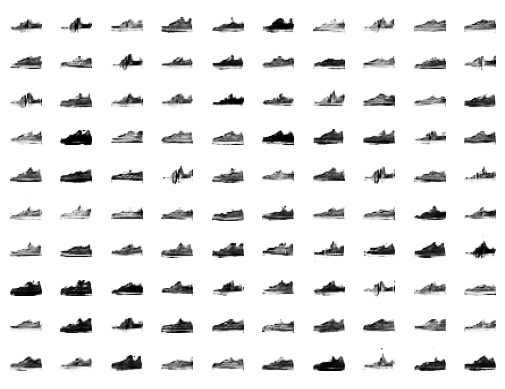

In [58]:

# example of loading the generator model and generating images
from math import sqrt
from numpy import asarray
from numpy.random import randn
from keras.models import load_model
from matplotlib import pyplot
 
# generate points in latent space as input for the generator
def generate_latent_points2(latent_dim, n_samples, n_class):
 # generate points in the latent space
 x_input = randn(latent_dim * n_samples)
 # reshape into a batch of inputs for the network
 z_input = x_input.reshape(n_samples, latent_dim)
 # generate labels
 labels = asarray([n_class for _ in range(n_samples)])
 return [z_input, labels]
 
# create and save a plot of generated images
def save_plot(examples, n_examples):
 # plot images
 for i in range(n_examples):
   # define subplot
   plt.subplot(sqrt(n_examples), sqrt(n_examples), 1 + i)
   # turn off axis
   plt.axis('off')
   # plot raw pixel data
   plt.imshow(examples[i, :, :, 0], cmap='gray_r')
 plt.show()
 
# load model
model = load_model('model_9370.h5')
latent_dim = 100
n_examples = 100 # must be a square
n_class = 7 # La clase, un sneaker
# generate images
latent_points, labels = generate_latent_points2(latent_dim, n_examples, n_class)
# generate images
X  = model.predict([latent_points, labels])
# scale from [-1,1] to [0,1]
X = (X + 1) / 2.0
# plot the result
save_plot(X, n_examples)